In [15]:
import os
import pandas as pd
import librosa
from tqdm import tqdm
import torch
import numpy as np
import time
import shutil
import glob
import librosa
import librosa.display
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Add, ZeroPadding2D, BatchNormalization, Activation

# 호흡음별로 데이터 나누기

In [10]:
folder = "D:/Data/호흡데이터/"
folder_path = "D:/Data/호흡데이터/ICBHI_final_database/"

# 폴더 이름에 대한 딕셔너리 생성
folder_names = {
    "normal": {"crack": 0, "wheezes": 0},
    "wheezes": {"crack": 0, "wheezes": 1},
    "crack": {"crack": 1, "wheezes": 0},
    "both": {"crack": 1, "wheezes": 1},
}

# 폴더 안에 있는 모든 .wav 파일의 경로 불러오기
wav_files = glob.glob(os.path.join(folder_path, "*.wav"))

# .wav 파일 분할 및 저장하는 함수
def split_wav_by_annotations(wav_file_path, annotations_file_path):
    # .txt 파일에서 호흡 주기 정보 읽어오기
    with open(annotations_file_path, 'r') as f:
        annotations = f.readlines()

    # 호흡 주기별로 .wav 파일 분할
    for annotation in annotations:
        annotation = annotation.strip().split()  # .txt 파일에서 주석 정보 추출
        start_time = float(annotation[0])  # 호흡 주기 시작 시간
        end_time = float(annotation[1])  # 호흡 주기 끝 시간
        crack = int(annotation[2])
        wheezes = int(annotation[3])
        
        # .wav 파일 분할하여 저장할 폴더 경로 설정
        folder_name = f"crack_{crack}_wheezes_{wheezes}"
        folder_path = os.path.join(folder, folder_name)
        
        # 호흡 주기에 해당하는 .wav 파일 저장 경로 설정
        filename = os.path.splitext(os.path.basename(wav_file_path))[0]
        save_path = os.path.join(folder_path, f"{filename}_cycle_{start_time}_{end_time}.wav")
        
        # 분할된 .wav 파일 저장
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        os.system(f"ffmpeg -i {wav_file_path} -ss {start_time} -to {end_time} -c copy {save_path}")

        if os.path.exists(save_path):
            print(f"Saved: {save_path}")
        else:
            print(f"Failed to save: {save_path}")

# .wav 파일별로 .txt 파일 경로 찾아서 호흡 주기별로 .wav 파일 분할
for wav_file in wav_files:
    print(wav_file)
    annotations_file_path = os.path.splitext(wav_file)[0] + '.txt'  # .txt 파일 경로
    if os.path.exists(annotations_file_path):
        split_wav_by_annotations(wav_file, annotations_file_path)
    else:
        print(f"No annotations found for {wav_file}")

D:/Data/호흡데이터/ICBHI_final_database\101_1b1_Al_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_0.036_0.579.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_0.579_2.45.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_2.45_3.893.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_3.893_5.793.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_5.793_7.521.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_7.521_9.279.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_9.279_11.15.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_11.15_13.036.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_13.036_14.721.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_14.721_16.707.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\101_1b1_Al_sc_Meditron_cycle_16.707_18.507.wav
Saved: D:

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\104_1b1_Pr_sc_Litt3200_cycle_10.199_12.817.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\104_1b1_Pr_sc_Litt3200_cycle_12.817_15.006.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\104_1b1_Pr_sc_Litt3200_cycle_15.006_18.439.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\104_1b1_Pr_sc_Litt3200_cycle_18.439_19.633.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\104_1b1_Pr_sc_Litt3200_cycle_19.633_20.387.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\104_1b1_Pr_sc_Litt3200_cycle_20.387_22.209.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\104_1b1_Pr_sc_Litt3200_cycle_22.209_23.728.wav
D:/Data/호흡데이터/ICBHI_final_database\105_1b1_Tc_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\105_1b1_Tc_sc_Meditron_cycle_0.036_2.279.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\105_1b1_Tc_sc_Meditron_cycle_2.279_4.879.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\105_1b1_Tc_sc_Meditron_cycle_4.879_7.507.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\105_1b1_Tc_sc_Meditron_cycle_7.507_10.336.wav

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Al_mc_AKGC417L_cycle_1.018_3.411.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Al_mc_AKGC417L_cycle_3.411_5.827.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\107_2b4_Al_mc_AKGC417L_cycle_5.827_8.339.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Al_mc_AKGC417L_cycle_8.339_10.923.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\107_2b4_Al_mc_AKGC417L_cycle_10.923_13.292.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Al_mc_AKGC417L_cycle_13.292_16.018.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Al_mc_AKGC417L_cycle_16.018_18.482.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Al_mc_AKGC417L_cycle_18.482_19.542.wav
D:/Data/호흡데이터/ICBHI_final_database\107_2b4_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Ar_mc_AKGC417L_cycle_1.018_3.411.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Ar_mc_AKGC417L_cycle_3.411_5.827.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b4_Ar_mc_AKGC417L_cycle_5.827_8.339.wav
Saved

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\107_2b5_Pl_mc_AKGC417L_cycle_8.97_11.542.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\107_2b5_Pl_mc_AKGC417L_cycle_11.542_14.077.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\107_2b5_Pl_mc_AKGC417L_cycle_14.077_16.625.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\107_2b5_Pl_mc_AKGC417L_cycle_16.625_19.339.wav
D:/Data/호흡데이터/ICBHI_final_database\107_2b5_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\107_2b5_Pr_mc_AKGC417L_cycle_0.077_1.411.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b5_Pr_mc_AKGC417L_cycle_1.411_3.863.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\107_2b5_Pr_mc_AKGC417L_cycle_3.863_6.601.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b5_Pr_mc_AKGC417L_cycle_6.601_8.97.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b5_Pr_mc_AKGC417L_cycle_8.97_11.542.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\107_2b5_Pr_mc_AKGC417L_cycle_11.542_14.077.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\107_2b5_Pr_mc_AKGC417L_cycle_14.077_16.625.wav
Saved

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\108_1b1_Al_sc_Meditron_cycle_18.836_19.936.wav
D:/Data/호흡데이터/ICBHI_final_database\109_1b1_Al_sc_Litt3200.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_0.0_2.3288.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_2.3288_4.0934.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_4.0934_5.7138.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_5.7138_7.6096.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_7.6096_9.512.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_9.512_11.368.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_11.368_13.166.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_13.166_16.931.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\109_1b1_Al_sc_Litt3200_cycle_16.931_20.336.wav
D:/Data/호흡데이터/ICBHI_final_database\109_1b1_Ar_sc_Litt3200.wav
Saved: D:/Data/호흡데이터/

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\110_1p1_Lr_sc_Meditron_cycle_7.4803_10.842.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\110_1p1_Lr_sc_Meditron_cycle_10.842_15.069.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\110_1p1_Lr_sc_Meditron_cycle_15.069_19.075.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\110_1p1_Lr_sc_Meditron_cycle_19.075_23.553.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\110_1p1_Lr_sc_Meditron_cycle_23.553_27.68.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\110_1p1_Lr_sc_Meditron_cycle_27.68_32.4.wav
D:/Data/호흡데이터/ICBHI_final_database\110_1p1_Pr_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\110_1p1_Pr_sc_Meditron_cycle_0.91028_6.4933.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\110_1p1_Pr_sc_Meditron_cycle_6.4933_10.911.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\110_1p1_Pr_sc_Meditron_cycle_10.911_14.176.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\110_1p1_Pr_sc_Meditron_cycle_14.176_18.291.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\110_1p1_Pr_sc_Meditron_cycle_18.291_23.497

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\112_1p1_Pr_sc_Litt3200_cycle_14.865_17.787.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\112_1p1_Pr_sc_Litt3200_cycle_17.787_20.71.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\112_1p1_Pr_sc_Litt3200_cycle_20.71_23.874.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\112_1p1_Pr_sc_Litt3200_cycle_23.874_26.652.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\112_1p1_Pr_sc_Litt3200_cycle_26.652_30.0.wav
D:/Data/호흡데이터/ICBHI_final_database\113_1b1_Al_sc_Litt3200.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\113_1b1_Al_sc_Litt3200_cycle_1.4576_2.8118.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\113_1b1_Al_sc_Litt3200_cycle_2.8118_4.6079.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\113_1b1_Al_sc_Litt3200_cycle_4.6079_6.0937.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\113_1b1_Al_sc_Litt3200_cycle_6.0937_7.3209.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\113_1b1_Al_sc_Litt3200_cycle_7.3209_8.5622.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\113_1b1_Al_sc_Litt3200_cycle_8.5622_9.9869.

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_0.393_1.236.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_1.236_2.193.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_2.193_2.979.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_2.979_3.922.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_3.922_4.736.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_4.736_5.664.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_5.664_6.593.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_6.593_7.393.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_7.393_8.221.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_8.221_9.236.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\115_1b1_Ar_sc_Meditron_cycle_9.236_10.164.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\115_1b1_Ar_sc_Meditron_cycle_10.164_

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\119_1b1_Ar_sc_Meditron_cycle_14.521_16.936.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\119_1b1_Ar_sc_Meditron_cycle_16.936_19.293.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\119_1b1_Ar_sc_Meditron_cycle_19.293_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\120_1b1_Al_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_0.89359_3.4344.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_3.4344_6.0183.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_6.0183_8.9467.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_8.9467_11.337.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_11.337_16.612.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_16.612_19.121.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_19.121_21.834.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Al_sc_Meditron_cycle_21.834_24

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_46.495_48.213.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_48.213_50.072.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_50.072_52.126.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_52.126_53.713.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_53.713_55.594.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_55.594_57.333.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_57.333_58.964.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_58.964_60.671.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_60.671_62.236.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_62.236_63.943.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_Meditron_cycle_63.943_65.519.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\120_1b1_Pl_sc_M

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\122_2b3_Ar_mc_LittC2SE_cycle_4.207_7.893.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Ar_mc_LittC2SE_cycle_7.893_12.221.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Ar_mc_LittC2SE_cycle_12.221_16.593.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Ar_mc_LittC2SE_cycle_16.593_19.95.wav
D:/Data/호흡데이터/ICBHI_final_database\122_2b3_Tc_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Tc_mc_LittC2SE_cycle_0.036_4.079.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Tc_mc_LittC2SE_cycle_4.079_7.95.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Tc_mc_LittC2SE_cycle_7.95_12.321.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Tc_mc_LittC2SE_cycle_12.321_16.607.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\122_2b3_Tc_mc_LittC2SE_cycle_16.607_19.993.wav
D:/Data/호흡데이터/ICBHI_final_database\123_1b1_Al_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\123_1b1_Al_sc_Meditron_cycle_0.45_2.979.wav
Saved: D:/Data/호흡데이터/crack_0_w

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\127_1b1_Ar_sc_Meditron_cycle_19.421_19.934.wav
D:/Data/호흡데이터/ICBHI_final_database\128_1b3_Tc_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\128_1b3_Tc_mc_LittC2SE_cycle_0.022_3.15.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\128_1b3_Tc_mc_LittC2SE_cycle_3.15_8.107.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\128_1b3_Tc_mc_LittC2SE_cycle_8.107_13.664.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\128_1b3_Tc_mc_LittC2SE_cycle_13.664_19.35.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\128_1b3_Tc_mc_LittC2SE_cycle_19.35_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\129_1b1_Ar_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\129_1b1_Ar_sc_Meditron_cycle_0.036_1.322.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\129_1b1_Ar_sc_Meditron_cycle_1.322_3.993.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\129_1b1_Ar_sc_Meditron_cycle_3.993_6.593.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\129_1b1_Ar_sc_Meditron_cycle_6.593_8.821.wav
Saved: D:/Data/호흡데이터/crack_1_whee

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\130_1p3_Pl_mc_AKGC417L_cycle_8.256_11.673.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\130_1p3_Pl_mc_AKGC417L_cycle_11.673_15.077.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\130_1p3_Pl_mc_AKGC417L_cycle_15.077_18.375.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_1p3_Pl_mc_AKGC417L_cycle_18.375_19.946.wav
D:/Data/호흡데이터/ICBHI_final_database\130_1p3_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\130_1p3_Pr_mc_AKGC417L_cycle_1.066_4.899.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_1p3_Pr_mc_AKGC417L_cycle_4.899_8.256.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\130_1p3_Pr_mc_AKGC417L_cycle_8.256_11.673.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_1p3_Pr_mc_AKGC417L_cycle_11.673_15.077.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_1p3_Pr_mc_AKGC417L_cycle_15.077_18.375.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_1p3_Pr_mc_AKGC417L_cycle_18.375_19.946.wav
D:/Data/호흡데이터/ICBHI_final_database\130_1p3_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/c

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_0.069_2.563.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_2.563_4.933.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_4.933_7.466.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_7.466_10.124.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_10.124_12.707.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_12.707_15.078.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_15.078_17.615.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Lr_mc_AKGC417L_cycle_17.615_19.946.wav
D:/Data/호흡데이터/ICBHI_final_database\130_2b2_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Pl_mc_AKGC417L_cycle_0.069_2.563.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Pl_mc_AKGC417L_cycle_2.563_4.933.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b2_Pl_mc_AKGC417L_cycle_4.933_7.466.wav
Saved

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_2b3_Tc_mc_AKGC417L_cycle_8.542_10.744.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_2b3_Tc_mc_AKGC417L_cycle_10.744_12.958.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_2b3_Tc_mc_AKGC417L_cycle_12.958_14.875.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_2b3_Tc_mc_AKGC417L_cycle_14.875_16.946.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_2b3_Tc_mc_AKGC417L_cycle_16.946_19.156.wav
D:/Data/호흡데이터/ICBHI_final_database\130_2b4_Al_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_2b4_Al_mc_AKGC417L_cycle_0.338_1.399.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b4_Al_mc_AKGC417L_cycle_1.399_3.768.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b4_Al_mc_AKGC417L_cycle_3.768_5.875.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b4_Al_mc_AKGC417L_cycle_5.875_8.173.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b4_Al_mc_AKGC417L_cycle_8.173_10.542.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2b4_Al_mc_AKGC417L_cycle_10.542_12.673.wav
Sa

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Lr_mc_AKGC417L_cycle_15.978_17.937.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Lr_mc_AKGC417L_cycle_17.937_19.362.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\130_2p5_Lr_mc_AKGC417L_cycle_19.362_19.958.wav
D:/Data/호흡데이터/ICBHI_final_database\130_2p5_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Pl_mc_AKGC417L_cycle_0.042_1.785.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Pl_mc_AKGC417L_cycle_1.785_3.922.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Pl_mc_AKGC417L_cycle_3.922_5.937.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Pl_mc_AKGC417L_cycle_5.937_7.83.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Pl_mc_AKGC417L_cycle_7.83_9.794.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\130_2p5_Pl_mc_AKGC417L_cycle_9.794_11.56.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_2p5_Pl_mc_AKGC417L_cycle_11.56_13.952.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\130_2p5_Pl_mc_AKGC417L_cycle_13.952_15.978.wav
Saved: 

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Pr_mc_AKGC417L_cycle_1.461_2.918.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Pr_mc_AKGC417L_cycle_2.918_5.839.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Pr_mc_AKGC417L_cycle_5.839_8.605.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Pr_mc_AKGC417L_cycle_8.605_11.637.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Pr_mc_AKGC417L_cycle_11.637_14.492.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Pr_mc_AKGC417L_cycle_14.492_17.389.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Pr_mc_AKGC417L_cycle_17.389_18.796.wav
D:/Data/호흡데이터/ICBHI_final_database\130_3p2_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Tc_mc_AKGC417L_cycle_1.461_2.918.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Tc_mc_AKGC417L_cycle_2.918_5.839.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Tc_mc_AKGC417L_cycle_5.839_8.605.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\130_3p2_Tc_mc_AKGC417L_cycle_8.605_11.637.wav
Saved:

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b1_Lr_mc_LittC2SE_cycle_9.021_11.25.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b1_Lr_mc_LittC2SE_cycle_11.25_13.65.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b1_Lr_mc_LittC2SE_cycle_13.65_15.736.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b1_Lr_mc_LittC2SE_cycle_15.736_17.979.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b1_Lr_mc_LittC2SE_cycle_17.979_19.936.wav
D:/Data/호흡데이터/ICBHI_final_database\132_2b2_Lr_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\132_2b2_Lr_mc_LittC2SE_cycle_0.007_1.864.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b2_Lr_mc_LittC2SE_cycle_1.864_4.022.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b2_Lr_mc_LittC2SE_cycle_4.022_6.25.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b2_Lr_mc_LittC2SE_cycle_6.25_8.536.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b2_Lr_mc_LittC2SE_cycle_8.536_10.807.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\132_2b2_Lr_mc_LittC2SE_cycle_10.807_13.226.wav
Saved: D

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Al_mc_AKGC417L_cycle_1.066_3.554.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Al_mc_AKGC417L_cycle_3.554_5.923.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Al_mc_AKGC417L_cycle_5.923_8.375.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Al_mc_AKGC417L_cycle_8.375_10.78.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Al_mc_AKGC417L_cycle_10.78_13.161.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\133_2p4_Al_mc_AKGC417L_cycle_13.161_15.78.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\133_2p4_Al_mc_AKGC417L_cycle_15.78_18.292.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Al_mc_AKGC417L_cycle_18.292_19.47.wav
D:/Data/호흡데이터/ICBHI_final_database\133_2p4_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\133_2p4_Ar_mc_AKGC417L_cycle_1.066_3.554.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Ar_mc_AKGC417L_cycle_3.554_5.923.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\133_2p4_Ar_mc_AKGC417L_cycle_5.923_8.375.wav
Saved: D:/

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Al_mc_LittC2SE_cycle_4.779_8.421.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Al_mc_LittC2SE_cycle_8.421_12.236.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Al_mc_LittC2SE_cycle_12.236_15.693.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Al_mc_LittC2SE_cycle_15.693_19.593.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Al_mc_LittC2SE_cycle_19.593_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\134_2b2_Ar_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Ar_mc_LittC2SE_cycle_0.05_0.479.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Ar_mc_LittC2SE_cycle_0.479_4.65.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Ar_mc_LittC2SE_cycle_4.65_8.35.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Ar_mc_LittC2SE_cycle_8.35_12.221.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Ar_mc_LittC2SE_cycle_12.221_15.636.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\134_2b2_Ar_mc_LittC2SE_cycle_15.636_19.521.wav
Saved: 

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Al_mc_LittC2SE_cycle_9.193_13.021.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Al_mc_LittC2SE_cycle_13.021_15.164.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Al_mc_LittC2SE_cycle_15.164_17.464.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Al_mc_LittC2SE_cycle_17.464_19.636.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Al_mc_LittC2SE_cycle_19.636_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\135_2b3_Ar_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Ar_mc_LittC2SE_cycle_0.093_2.522.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Ar_mc_LittC2SE_cycle_2.522_4.836.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Ar_mc_LittC2SE_cycle_4.836_7.007.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Ar_mc_LittC2SE_cycle_7.007_9.15.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Ar_mc_LittC2SE_cycle_9.15_12.95.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\135_2b3_Ar_mc_LittC2SE_cycle_12.95_15.107.wav
Saved:

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_1p2_Pl_mc_AKGC417L_cycle_7.855_11.461.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_1p2_Pl_mc_AKGC417L_cycle_11.461_15.568.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_1p2_Pl_mc_AKGC417L_cycle_15.568_19.157.wav
D:/Data/호흡데이터/ICBHI_final_database\138_1p2_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\138_1p2_Pr_mc_AKGC417L_cycle_0.159_3.715.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\138_1p2_Pr_mc_AKGC417L_cycle_3.715_7.855.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_1p2_Pr_mc_AKGC417L_cycle_7.855_11.461.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_1p2_Pr_mc_AKGC417L_cycle_11.461_15.568.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_1p2_Pr_mc_AKGC417L_cycle_15.568_19.157.wav
D:/Data/호흡데이터/ICBHI_final_database\138_1p2_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\138_1p2_Tc_mc_AKGC417L_cycle_0.159_3.715.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\138_1p2_Tc_mc_AKGC417L_cycle_3.715_7.855.wav
Saved: D:/Data/호흡데이터/crack

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\138_2p2_Ar_mc_AKGC417L_cycle_1.644_3.18.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_2p2_Ar_mc_AKGC417L_cycle_3.18_6.035.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\138_2p2_Ar_mc_AKGC417L_cycle_6.035_8.94.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_2p2_Ar_mc_AKGC417L_cycle_8.94_11.828.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_2p2_Ar_mc_AKGC417L_cycle_11.828_14.449.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_2p2_Ar_mc_AKGC417L_cycle_14.449_17.654.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\138_2p2_Ar_mc_AKGC417L_cycle_17.654_19.04.wav
D:/Data/호흡데이터/ICBHI_final_database\138_2p2_Ll_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\138_2p2_Ll_mc_AKGC417L_cycle_1.644_3.18.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\138_2p2_Ll_mc_AKGC417L_cycle_3.18_6.035.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\138_2p2_Ll_mc_AKGC417L_cycle_6.035_8.94.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\138_2p2_Ll_mc_AKGC417L_cycle_8.94_11.828.wav
Saved: D:/Data/

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_3.107_5.179.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_5.179_7.107.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_7.107_9.564.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_9.564_11.45.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_11.45_13.436.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_13.436_15.479.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_15.479_17.479.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_17.479_19.736.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Ll_mc_LittC2SE_cycle_19.736_19.993.wav
D:/Data/호흡데이터/ICBHI_final_database\140_2b2_Tc_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\140_2b2_Tc_mc_LittC2SE_cycle_0.036_1.85.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\140_2b2_Tc_mc_LittC2SE_cycle_1.85_4.079.wav
Saved: 

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\142_1b1_Pl_mc_LittC2SE_cycle_19.35_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\143_1b1_Al_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_0.064_0.822.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_0.822_1.979.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_1.979_3.279.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_3.279_4.721.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_4.721_5.964.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_5.964_7.179.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_7.179_8.764.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_8.764_9.707.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_9.707_10.621.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\143_1b1_Al_sc_Meditron_cycle_10.621_11.607.wav
Saved: D:/

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ar_mc_AKGC417L_cycle_15.411_19.089.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ar_mc_AKGC417L_cycle_19.089_19.97.wav
D:/Data/호흡데이터/ICBHI_final_database\146_2b4_Ll_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ll_mc_AKGC417L_cycle_0.089_3.542.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ll_mc_AKGC417L_cycle_3.542_7.542.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ll_mc_AKGC417L_cycle_7.542_11.554.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ll_mc_AKGC417L_cycle_11.554_15.589.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ll_mc_AKGC417L_cycle_15.589_19.196.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Ll_mc_AKGC417L_cycle_19.196_19.946.wav
D:/Data/호흡데이터/ICBHI_final_database\146_2b4_Lr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Lr_mc_AKGC417L_cycle_0.089_3.78.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\146_2b4_Lr_mc_AKGC417L_cycle_3.78_7.542.wav
Saved: D:/Data/호흡데이터/crack_0

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\147_1b4_Tc_mc_AKGC417L_cycle_5.663_7.005.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\147_1b4_Tc_mc_AKGC417L_cycle_7.005_8.297.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\147_1b4_Tc_mc_AKGC417L_cycle_8.297_9.472.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\147_1b4_Tc_mc_AKGC417L_cycle_9.472_10.713.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\147_1b4_Tc_mc_AKGC417L_cycle_10.713_11.921.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\147_1b4_Tc_mc_AKGC417L_cycle_11.921_13.28.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\147_1b4_Tc_mc_AKGC417L_cycle_13.28_14.589.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\147_1b4_Tc_mc_AKGC417L_cycle_14.589_15.78.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\147_1b4_Tc_mc_AKGC417L_cycle_15.78_17.039.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\147_1b4_Tc_mc_AKGC417L_cycle_17.039_18.28.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\147_1b4_Tc_mc_AKGC417L_cycle_18.28_19.522.wav
D:/Data/호흡데이터/ICBHI_final_database\147_2b2_Al_mc_AKGC417L.wav
Saved

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\149_1b1_Al_sc_Meditron_cycle_0.807_1.393.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_1.393_2.15.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_2.15_3.136.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\149_1b1_Al_sc_Meditron_cycle_3.136_4.193.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_4.193_5.436.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\149_1b1_Al_sc_Meditron_cycle_5.436_6.636.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\149_1b1_Al_sc_Meditron_cycle_6.636_7.936.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_7.936_9.364.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_9.364_10.764.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_10.764_12.121.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_12.121_13.179.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\149_1b1_Al_sc_Meditron_cycle_13.17

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p2_Pl_mc_AKGC417L_cycle_12.179_15.701.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\151_2p2_Pl_mc_AKGC417L_cycle_15.701_19.157.wav
D:/Data/호흡데이터/ICBHI_final_database\151_2p2_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\151_2p2_Pr_mc_AKGC417L_cycle_0.609_2.412.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p2_Pr_mc_AKGC417L_cycle_2.412_5.601.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p2_Pr_mc_AKGC417L_cycle_5.601_8.74.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p2_Pr_mc_AKGC417L_cycle_8.74_12.179.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p2_Pr_mc_AKGC417L_cycle_12.179_15.701.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p2_Pr_mc_AKGC417L_cycle_15.701_19.157.wav
D:/Data/호흡데이터/ICBHI_final_database\151_2p2_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p2_Tc_mc_AKGC417L_cycle_0.609_2.412.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\151_2p2_Tc_mc_AKGC417L_cycle_2.412_5.601.wav
Saved: D:/Data/호흡데이터/crack_0_

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p4_Pr_mc_AKGC417L_cycle_6.486_10.175.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p4_Pr_mc_AKGC417L_cycle_10.175_13.648.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p4_Pr_mc_AKGC417L_cycle_13.648_16.185.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p4_Pr_mc_AKGC417L_cycle_16.185_18.756.wav
D:/Data/호흡데이터/ICBHI_final_database\151_2p4_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p4_Tc_mc_AKGC417L_cycle_0.059_2.897.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\151_2p4_Tc_mc_AKGC417L_cycle_2.897_6.486.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\151_2p4_Tc_mc_AKGC417L_cycle_6.486_10.175.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p4_Tc_mc_AKGC417L_cycle_10.175_13.648.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\151_2p4_Tc_mc_AKGC417L_cycle_13.648_16.185.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\151_2p4_Tc_mc_AKGC417L_cycle_16.185_18.756.wav
D:/Data/호흡데이터/ICBHI_final_database\151_3p2_Al_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/c

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_1b3_Ar_mc_AKGC417L_cycle_16.101_17.613.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_1b3_Ar_mc_AKGC417L_cycle_17.613_19.089.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_1b3_Ar_mc_AKGC417L_cycle_19.089_19.827.wav
D:/Data/호흡데이터/ICBHI_final_database\154_1b3_Ll_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_0.399_2.327.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_2.327_4.316.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_4.316_6.149.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_6.149_8.042.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_8.042_9.816.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_9.816_11.554.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_11.554_13.089.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_1b3_Ll_mc_AKGC417L_cycle_13.089_14.566.wav
Sav

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_2b4_Pl_mc_AKGC417L_cycle_3.804_6.396.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_2b4_Pl_mc_AKGC417L_cycle_6.396_8.938.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_2b4_Pl_mc_AKGC417L_cycle_8.938_11.58.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_2b4_Pl_mc_AKGC417L_cycle_11.58_14.072.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_2b4_Pl_mc_AKGC417L_cycle_14.072_17.049.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_2b4_Pl_mc_AKGC417L_cycle_17.049_19.49.wav
D:/Data/호흡데이터/ICBHI_final_database\154_2b4_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_2b4_Pr_mc_AKGC417L_cycle_1.33_3.804.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_2b4_Pr_mc_AKGC417L_cycle_3.804_6.396.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_2b4_Pr_mc_AKGC417L_cycle_6.396_8.938.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_2b4_Pr_mc_AKGC417L_cycle_8.938_11.58.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_2b4_Pr_mc_AKGC417L_cycle_11.58_14.072.wav
Saved: D:/

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_4b4_Pr_mc_AKGC417L_cycle_8.458_10.444.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_4b4_Pr_mc_AKGC417L_cycle_10.444_12.423.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_4b4_Pr_mc_AKGC417L_cycle_12.423_14.732.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\154_4b4_Pr_mc_AKGC417L_cycle_14.732_16.851.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_4b4_Pr_mc_AKGC417L_cycle_16.851_18.78.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\154_4b4_Pr_mc_AKGC417L_cycle_18.78_19.696.wav
D:/Data/호흡데이터/ICBHI_final_database\155_2b1_Al_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\155_2b1_Al_mc_LittC2SE_cycle_0.193_3.922.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\155_2b1_Al_mc_LittC2SE_cycle_3.922_7.65.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\155_2b1_Al_mc_LittC2SE_cycle_7.65_11.664.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\155_2b1_Al_mc_LittC2SE_cycle_11.664_15.493.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\155_2b1_Al_mc_LittC2SE_cycle_15.493_19.079.wav
Sa

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\156_5b3_Pl_mc_AKGC417L_cycle_12.773_15.089.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pl_mc_AKGC417L_cycle_15.089_17.263.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\156_5b3_Pl_mc_AKGC417L_cycle_17.263_19.672.wav
D:/Data/호흡데이터/ICBHI_final_database\156_5b3_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_0.016_2.035.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_2.035_4.208.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_4.208_6.435.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_6.435_8.437.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_8.437_10.552.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_10.552_12.773.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_12.773_15.089.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\156_5b3_Pr_mc_AKGC417L_cycle_15.089_17.263.wav
S

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_18.747_24.151.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_24.151_30.481.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_30.481_34.98.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_34.98_40.17.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_40.17_45.055.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_45.055_49.116.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_49.116_53.92.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_53.92_59.558.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\157_1b1_Pl_sc_Meditron_cycle_59.558_63.1.wav
D:/Data/호흡데이터/ICBHI_final_database\157_1b1_Pr_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\157_1b1_Pr_sc_Meditron_cycle_1.3841_4.9768.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\157_1b1_Pr_sc_Meditron_cycle_4.9768_8.1521.wav


Saved: D:/Data/호흡데이터/crack_0_wheezes_1\158_1p3_Al_mc_AKGC417L_cycle_0.609_2.212.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p3_Al_mc_AKGC417L_cycle_2.212_5.05.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p3_Al_mc_AKGC417L_cycle_5.05_7.454.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\158_1p3_Al_mc_AKGC417L_cycle_7.454_9.808.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p3_Al_mc_AKGC417L_cycle_9.808_12.079.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p3_Al_mc_AKGC417L_cycle_12.079_14.282.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\158_1p3_Al_mc_AKGC417L_cycle_14.282_16.536.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\158_1p3_Al_mc_AKGC417L_cycle_16.536_18.823.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\158_1p3_Al_mc_AKGC417L_cycle_18.823_19.674.wav
D:/Data/호흡데이터/ICBHI_final_database\158_1p3_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p3_Ar_mc_AKGC417L_cycle_0.609_2.212.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\158_1p3_Ar_mc_AKGC417L_cycle_2.212_5.05.wav
Saved: D

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\158_1p4_Pl_mc_AKGC417L_cycle_7.387_9.541.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\158_1p4_Pl_mc_AKGC417L_cycle_9.541_11.611.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\158_1p4_Pl_mc_AKGC417L_cycle_11.611_13.848.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\158_1p4_Pl_mc_AKGC417L_cycle_13.848_15.918.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p4_Pl_mc_AKGC417L_cycle_15.918_17.972.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p4_Pl_mc_AKGC417L_cycle_17.972_19.992.wav
D:/Data/호흡데이터/ICBHI_final_database\158_1p4_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\158_1p4_Pr_mc_AKGC417L_cycle_0.509_2.98.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p4_Pr_mc_AKGC417L_cycle_2.98_5.217.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p4_Pr_mc_AKGC417L_cycle_5.217_7.387.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p4_Pr_mc_AKGC417L_cycle_7.387_9.541.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\158_1p4_Pr_mc_AKGC417L_cycle_9.541_11.611.wav
Saved:

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\159_1b1_Pr_sc_Meditron_cycle_4.593_7.364.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\159_1b1_Pr_sc_Meditron_cycle_7.364_9.393.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\159_1b1_Pr_sc_Meditron_cycle_9.393_11.764.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\159_1b1_Pr_sc_Meditron_cycle_11.764_14.05.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\159_1b1_Pr_sc_Meditron_cycle_14.05_16.521.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\159_1b1_Pr_sc_Meditron_cycle_16.521_18.907.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\159_1b1_Pr_sc_Meditron_cycle_18.907_19.979.wav
D:/Data/호흡데이터/ICBHI_final_database\160_1b2_Al_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\160_1b2_Al_mc_AKGC417L_cycle_0.109_4.766.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\160_1b2_Al_mc_AKGC417L_cycle_4.766_10.342.wav
D:/Data/호흡데이터/ICBHI_final_database\160_1b2_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\160_1b2_Ar_mc_AKGC417L_cycle_0.109_4.766.wav
Saved: D:/Data/호흡데이터/crack_0

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Ar_mc_AKGC417L_cycle_9.942_12.613.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Ar_mc_AKGC417L_cycle_12.613_15.301.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Ar_mc_AKGC417L_cycle_15.301_17.922.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Ar_mc_AKGC417L_cycle_17.922_18.957.wav
D:/Data/호흡데이터/ICBHI_final_database\160_2b4_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Pl_mc_AKGC417L_cycle_1.945_4.716.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Pl_mc_AKGC417L_cycle_4.716_7.337.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Pl_mc_AKGC417L_cycle_7.337_9.942.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Pl_mc_AKGC417L_cycle_9.942_12.613.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Pl_mc_AKGC417L_cycle_12.613_15.301.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Pl_mc_AKGC417L_cycle_15.301_17.922.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\160_2b4_Pl_mc_AKGC417L_cycle_17.922_18.957.wav


Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b2_Tc_mc_AKGC417L_cycle_16.753_19.09.wav
D:/Data/호흡데이터/ICBHI_final_database\162_2b3_Al_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Al_mc_AKGC417L_cycle_0.109_4.099.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Al_mc_AKGC417L_cycle_4.099_10.776.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Al_mc_AKGC417L_cycle_10.776_17.12.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Al_mc_AKGC417L_cycle_17.12_18.99.wav
D:/Data/호흡데이터/ICBHI_final_database\162_2b3_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Ar_mc_AKGC417L_cycle_0.109_4.099.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Ar_mc_AKGC417L_cycle_4.099_10.776.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Ar_mc_AKGC417L_cycle_10.776_17.12.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Ar_mc_AKGC417L_cycle_17.12_18.99.wav
D:/Data/호흡데이터/ICBHI_final_database\162_2b3_Lr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\162_2b3_Lr_mc_

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Al_mc_AKGC417L_cycle_3.765_6.794.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Al_mc_AKGC417L_cycle_6.794_10.279.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Al_mc_AKGC417L_cycle_10.279_13.613.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Al_mc_AKGC417L_cycle_13.613_16.337.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Al_mc_AKGC417L_cycle_16.337_19.958.wav
D:/Data/호흡데이터/ICBHI_final_database\163_8b3_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Ar_mc_AKGC417L_cycle_0.432_3.765.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Ar_mc_AKGC417L_cycle_3.765_6.794.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Ar_mc_AKGC417L_cycle_6.794_10.279.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Ar_mc_AKGC417L_cycle_10.279_13.613.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Ar_mc_AKGC417L_cycle_13.613_16.337.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\163_8b3_Ar_mc_AKGC417L_cycle_16.337_19.958.wav


Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_18.91_21.074.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_21.074_23.244.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_23.244_25.223.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_25.223_27.182.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_27.182_29.033.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_29.033_30.852.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_30.852_32.709.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_32.709_34.41.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_34.41_37.11.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_37.11_39.805.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditron_cycle_39.805_42.639.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\166_1p1_Ar_sc_Meditr

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_7.393_8.75.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_8.75_10.05.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_10.05_11.55.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_11.55_12.95.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_12.95_14.521.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_14.521_16.036.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_16.036_17.321.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Al_sc_Meditron_cycle_17.321_17.879.wav
D:/Data/호흡데이터/ICBHI_final_database\167_1b1_Pr_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\167_1b1_Pr_sc_Meditron_cycle_0.036_1.036.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\167_1b1_Pr_sc_Meditron_cycle_1.036_2.364.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\167_1b1_Pr_sc_Meditron_cycle_2.364_3.693.wav
Saved: D:

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Ll_mc_AKGC417L_cycle_4.466_7.237.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Ll_mc_AKGC417L_cycle_7.237_10.125.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Ll_mc_AKGC417L_cycle_10.125_13.13.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Ll_mc_AKGC417L_cycle_13.13_16.302.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Ll_mc_AKGC417L_cycle_16.302_19.04.wav
D:/Data/호흡데이터/ICBHI_final_database\170_1b3_Lr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Lr_mc_AKGC417L_cycle_1.427_4.466.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Lr_mc_AKGC417L_cycle_4.466_7.237.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Lr_mc_AKGC417L_cycle_7.237_10.125.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\170_1b3_Lr_mc_AKGC417L_cycle_10.125_13.13.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Lr_mc_AKGC417L_cycle_13.13_16.302.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_1b3_Lr_mc_AKGC417L_cycle_16.302_19.04.wav
D:/Dat

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pl_mc_AKGC417L_cycle_2.479_5.768.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pl_mc_AKGC417L_cycle_5.768_8.806.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pl_mc_AKGC417L_cycle_8.806_11.928.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pl_mc_AKGC417L_cycle_11.928_15.117.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pl_mc_AKGC417L_cycle_15.117_18.406.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pl_mc_AKGC417L_cycle_18.406_19.407.wav
D:/Data/호흡데이터/ICBHI_final_database\170_2b2_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pr_mc_AKGC417L_cycle_0.509_2.479.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pr_mc_AKGC417L_cycle_2.479_5.768.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pr_mc_AKGC417L_cycle_5.768_8.806.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pr_mc_AKGC417L_cycle_8.806_11.928.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\170_2b2_Pr_mc_AKGC417L_cycle_11.928_15.117.wav
Save

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\172_1b4_Ar_mc_AKGC417L_cycle_13.898_17.186.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_1b4_Ar_mc_AKGC417L_cycle_17.186_19.959.wav
D:/Data/호흡데이터/ICBHI_final_database\172_1b4_Ll_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_1b4_Ll_mc_AKGC417L_cycle_3.464_5.868.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\172_1b4_Ll_mc_AKGC417L_cycle_5.868_8.473.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\172_1b4_Ll_mc_AKGC417L_cycle_8.473_11.027.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\172_1b4_Ll_mc_AKGC417L_cycle_11.027_13.898.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\172_1b4_Ll_mc_AKGC417L_cycle_13.898_17.186.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_1b4_Ll_mc_AKGC417L_cycle_17.186_19.959.wav
D:/Data/호흡데이터/ICBHI_final_database\172_1b4_Lr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_1b4_Lr_mc_AKGC417L_cycle_3.464_5.868.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\172_1b4_Lr_mc_AKGC417L_cycle_5.868_8.473.wav
Saved: D:/Data/호흡데이터/crac

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_2b5_Ar_mc_AKGC417L_cycle_7.387_10.175.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_2b5_Ar_mc_AKGC417L_cycle_10.175_12.897.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\172_2b5_Ar_mc_AKGC417L_cycle_12.897_15.634.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\172_2b5_Ar_mc_AKGC417L_cycle_15.634_18.84.wav
D:/Data/호흡데이터/ICBHI_final_database\172_2b5_Lr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_2b5_Lr_mc_AKGC417L_cycle_1.377_4.249.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\172_2b5_Lr_mc_AKGC417L_cycle_4.249_7.387.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_2b5_Lr_mc_AKGC417L_cycle_7.387_10.175.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_2b5_Lr_mc_AKGC417L_cycle_10.175_12.897.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\172_2b5_Lr_mc_AKGC417L_cycle_12.897_15.634.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\172_2b5_Lr_mc_AKGC417L_cycle_15.634_18.84.wav
D:/Data/호흡데이터/ICBHI_final_database\172_2b5_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/cra

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pl_mc_AKGC417L_cycle_0.326_4.282.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pl_mc_AKGC417L_cycle_4.282_7.638.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pl_mc_AKGC417L_cycle_7.638_11.427.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pl_mc_AKGC417L_cycle_11.427_15.2.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pl_mc_AKGC417L_cycle_15.2_18.89.wav
D:/Data/호흡데이터/ICBHI_final_database\174_1p3_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\174_1p3_Pr_mc_AKGC417L_cycle_0.326_4.282.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pr_mc_AKGC417L_cycle_4.282_7.638.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\174_1p3_Pr_mc_AKGC417L_cycle_7.638_11.427.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pr_mc_AKGC417L_cycle_11.427_15.2.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\174_1p3_Pr_mc_AKGC417L_cycle_15.2_18.89.wav
D:/Data/호흡데이터/ICBHI_final_database\174_1p3_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\175_1b1_Pr_sc_Litt3200_cycle_2.221_5.6038.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\175_1b1_Pr_sc_Litt3200_cycle_5.6038_11.181.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\175_1b1_Pr_sc_Litt3200_cycle_11.181_16.752.wav
D:/Data/호흡데이터/ICBHI_final_database\176_1b3_Al_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\176_1b3_Al_mc_AKGC417L_cycle_0.048_2.13.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_1b3_Al_mc_AKGC417L_cycle_2.13_6.245.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_1b3_Al_mc_AKGC417L_cycle_6.245_9.852.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_1b3_Al_mc_AKGC417L_cycle_9.852_13.423.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_1b3_Al_mc_AKGC417L_cycle_13.423_17.291.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_1b3_Al_mc_AKGC417L_cycle_17.291_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\176_1b3_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_1b3_Ar_mc_AKGC417L_cycle_0.048_2.13.wav
Saved: D:/Data/호흡데이터/crack_1_

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Al_mc_AKGC417L_cycle_7.995_11.193.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Al_mc_AKGC417L_cycle_11.193_14.256.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Al_mc_AKGC417L_cycle_14.256_17.2.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Al_mc_AKGC417L_cycle_17.2_19.975.wav
D:/Data/호흡데이터/ICBHI_final_database\176_2b3_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\176_2b3_Ar_mc_AKGC417L_cycle_0.093_1.785.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Ar_mc_AKGC417L_cycle_1.785_5.085.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Ar_mc_AKGC417L_cycle_5.085_7.995.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Ar_mc_AKGC417L_cycle_7.995_11.193.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Ar_mc_AKGC417L_cycle_11.193_14.256.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Ar_mc_AKGC417L_cycle_14.256_17.2.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\176_2b3_Ar_mc_AKGC417L_cycle_17.2_19.975.wav
D:/Data/

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\177_1b4_Pl_mc_AKGC417L_cycle_7.888_11.043.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\177_1b4_Pl_mc_AKGC417L_cycle_11.043_14.583.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\177_1b4_Pl_mc_AKGC417L_cycle_14.583_18.74.wav
D:/Data/호흡데이터/ICBHI_final_database\177_1b4_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\177_1b4_Pr_mc_AKGC417L_cycle_0.359_3.364.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\177_1b4_Pr_mc_AKGC417L_cycle_3.364_7.888.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\177_1b4_Pr_mc_AKGC417L_cycle_7.888_11.043.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\177_1b4_Pr_mc_AKGC417L_cycle_11.043_14.583.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\177_1b4_Pr_mc_AKGC417L_cycle_14.583_18.74.wav
D:/Data/호흡데이터/ICBHI_final_database\177_1b4_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\177_1b4_Tc_mc_AKGC417L_cycle_0.359_3.364.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\177_1b4_Tc_mc_AKGC417L_cycle_3.364_7.888.wav
Saved: D:/Data/호흡데이터/crack_0

Saved: D:/Data/호흡데이터/crack_1_wheezes_1\178_1b2_Pr_mc_AKGC417L_cycle_2.697_4.006.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\178_1b2_Pr_mc_AKGC417L_cycle_4.006_5.506.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\178_1b2_Pr_mc_AKGC417L_cycle_5.506_7.089.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\178_1b2_Pr_mc_AKGC417L_cycle_7.089_8.863.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b2_Pr_mc_AKGC417L_cycle_8.863_10.268.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\178_1b2_Pr_mc_AKGC417L_cycle_10.268_11.982.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b2_Pr_mc_AKGC417L_cycle_11.982_13.732.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b2_Pr_mc_AKGC417L_cycle_13.732_15.589.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b2_Pr_mc_AKGC417L_cycle_15.589_17.387.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b2_Pr_mc_AKGC417L_cycle_17.387_19.494.wav
D:/Data/호흡데이터/ICBHI_final_database\178_1b2_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b2_Tc_mc_AKGC417L_cycle_0.042_1.28.wav
Save

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pl_mc_AKGC417L_cycle_12.566_14.827.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pl_mc_AKGC417L_cycle_14.827_17.446.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pl_mc_AKGC417L_cycle_17.446_19.958.wav
D:/Data/호흡데이터/ICBHI_final_database\178_1b6_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pr_mc_AKGC417L_cycle_0.923_2.732.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\178_1b6_Pr_mc_AKGC417L_cycle_2.732_5.375.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pr_mc_AKGC417L_cycle_5.375_7.756.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pr_mc_AKGC417L_cycle_7.756_10.256.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pr_mc_AKGC417L_cycle_10.256_12.566.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pr_mc_AKGC417L_cycle_12.566_14.827.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\178_1b6_Pr_mc_AKGC417L_cycle_14.827_17.446.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\178_1b6_Pr_mc_AKGC417L_cycle_17.446_19.958.wav

Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Ar_mc_AKGC417L_cycle_4.72_8.494.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Ar_mc_AKGC417L_cycle_8.494_12.018.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Ar_mc_AKGC417L_cycle_12.018_15.554.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Ar_mc_AKGC417L_cycle_15.554_19.108.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\180_1b4_Ar_mc_AKGC417L_cycle_19.108_19.876.wav
D:/Data/호흡데이터/ICBHI_final_database\180_1b4_Lr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Lr_mc_AKGC417L_cycle_0.899_4.72.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Lr_mc_AKGC417L_cycle_4.72_8.494.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Lr_mc_AKGC417L_cycle_8.494_12.018.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Lr_mc_AKGC417L_cycle_12.018_15.554.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\180_1b4_Lr_mc_AKGC417L_cycle_15.554_19.108.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\180_1b4_Lr_mc_AKGC417L_cycle_19.108_19.876.wav
D:/

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Ll_sc_Litt3200_cycle_10.076_12.157.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Ll_sc_Litt3200_cycle_12.157_13.394.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\185_1b1_Ll_sc_Litt3200_cycle_13.394_16.257.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Ll_sc_Litt3200_cycle_16.257_19.376.wav
D:/Data/호흡데이터/ICBHI_final_database\185_1b1_Lr_sc_Litt3200.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Lr_sc_Litt3200_cycle_2.8751_5.2563.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Lr_sc_Litt3200_cycle_5.2563_7.1055.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Lr_sc_Litt3200_cycle_7.1055_9.0497.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Lr_sc_Litt3200_cycle_9.0497_10.753.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Lr_sc_Litt3200_cycle_10.753_12.71.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Lr_sc_Litt3200_cycle_12.71_15.68.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\185_1b1_Lr_sc_Litt3200_cycle_15.68_19.632.

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\186_2b3_Tc_mc_AKGC417L_cycle_4.554_8.53.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\186_2b3_Tc_mc_AKGC417L_cycle_8.53_12.589.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\186_2b3_Tc_mc_AKGC417L_cycle_12.589_16.649.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\186_2b3_Tc_mc_AKGC417L_cycle_16.649_18.208.wav
D:/Data/호흡데이터/ICBHI_final_database\186_2b4_Al_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\186_2b4_Al_mc_AKGC417L_cycle_1.185_5.268.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\186_2b4_Al_mc_AKGC417L_cycle_5.268_9.292.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\186_2b4_Al_mc_AKGC417L_cycle_9.292_13.435.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\186_2b4_Al_mc_AKGC417L_cycle_13.435_17.899.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\186_2b4_Al_mc_AKGC417L_cycle_17.899_19.506.wav
D:/Data/호흡데이터/ICBHI_final_database\186_2b4_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\186_2b4_Ar_mc_AKGC417L_cycle_1.185_5.268.wav
Saved: D:/Data/호흡데이터/crack_1

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_0.45_2.822.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_2.822_4.236.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_4.236_6.15.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_6.15_7.55.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_7.55_9.193.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_9.193_10.593.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_10.593_11.836.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_11.836_12.979.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_12.979_14.121.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_14.121_15.407.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_15.407_16.736.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\188_1b1_Al_sc_Meditron_cycle_16

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\191_2b2_Tc_mc_LittC2SE_cycle_18.864_19.821.wav
D:/Data/호흡데이터/ICBHI_final_database\192_2b1_Al_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\192_2b1_Al_mc_LittC2SE_cycle_0.022_1.007.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\192_2b1_Al_mc_LittC2SE_cycle_1.007_3.707.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\192_2b1_Al_mc_LittC2SE_cycle_3.707_6.979.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\192_2b1_Al_mc_LittC2SE_cycle_6.979_9.721.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\192_2b1_Al_mc_LittC2SE_cycle_9.721_12.564.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\192_2b1_Al_mc_LittC2SE_cycle_12.564_15.493.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\192_2b1_Al_mc_LittC2SE_cycle_15.493_18.393.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\192_2b1_Al_mc_LittC2SE_cycle_18.393_19.936.wav
D:/Data/호흡데이터/ICBHI_final_database\192_2b1_Ar_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\192_2b1_Ar_mc_LittC2SE_cycle_0.022_1.064.wav
Saved: D:/Data/호흡데이터/crack_

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pl_mc_AKGC417L_cycle_12.918_14.64.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pl_mc_AKGC417L_cycle_14.64_16.447.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pl_mc_AKGC417L_cycle_16.447_18.119.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pl_mc_AKGC417L_cycle_18.119_19.908.wav
D:/Data/호흡데이터/ICBHI_final_database\193_1b2_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pr_mc_AKGC417L_cycle_0.364_1.263.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pr_mc_AKGC417L_cycle_1.263_2.901.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pr_mc_AKGC417L_cycle_2.901_4.523.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pr_mc_AKGC417L_cycle_4.523_6.229.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pr_mc_AKGC417L_cycle_6.229_7.901.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pr_mc_AKGC417L_cycle_7.901_9.507.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\193_1b2_Pr_mc_AKGC417L_cycle_9.507_11.162.wav
Saved: 

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\193_7b3_Tc_mc_AKGC417L_cycle_11.673_13.839.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\193_7b3_Tc_mc_AKGC417L_cycle_13.839_16.446.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\193_7b3_Tc_mc_AKGC417L_cycle_16.446_19.065.wav
D:/Data/호흡데이터/ICBHI_final_database\194_1b1_Lr_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_0.022_1.636.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_1.636_4.179.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_4.179_6.564.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_6.564_9.093.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_9.093_11.436.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_11.436_13.95.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_13.95_16.764.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\194_1b1_Lr_sc_Meditron_cycle_16.764_19.364.wav
Sav

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\195_1b1_Pr_sc_Litt3200_cycle_23.598_26.269.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\195_1b1_Pr_sc_Litt3200_cycle_26.269_28.161.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\195_1b1_Pr_sc_Litt3200_cycle_28.161_30.0.wav
D:/Data/호흡데이터/ICBHI_final_database\196_1b1_Pr_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\196_1b1_Pr_sc_Meditron_cycle_0.022_3.436.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\196_1b1_Pr_sc_Meditron_cycle_3.436_6.922.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\196_1b1_Pr_sc_Meditron_cycle_6.922_10.107.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\196_1b1_Pr_sc_Meditron_cycle_10.107_13.293.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\196_1b1_Pr_sc_Meditron_cycle_13.293_16.464.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\196_1b1_Pr_sc_Meditron_cycle_16.464_19.95.wav
D:/Data/호흡데이터/ICBHI_final_database\197_1b1_Al_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\197_1b1_Al_sc_Meditron_cycle_0.022_7.179.wav
Saved: D:/Data/호흡데이터/crack

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Lr_mc_AKGC417L_cycle_4.049_6.94.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Lr_mc_AKGC417L_cycle_6.94_10.254.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Lr_mc_AKGC417L_cycle_10.254_13.466.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Lr_mc_AKGC417L_cycle_13.466_16.948.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Lr_mc_AKGC417L_cycle_16.948_19.535.wav
D:/Data/호흡데이터/ICBHI_final_database\198_6p1_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Pl_mc_AKGC417L_cycle_0.025_1.851.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Pl_mc_AKGC417L_cycle_1.851_4.776.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Pl_mc_AKGC417L_cycle_4.776_8.039.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Pl_mc_AKGC417L_cycle_8.039_10.812.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\198_6p1_Pl_mc_AKGC417L_cycle_10.812_13.855.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\198_6p1_Pl_mc_AKGC417L_cycle_13.855_16.746.wav
Save

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p3_Pr_mc_AKGC417L_cycle_7.788_13.881.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p3_Pr_mc_AKGC417L_cycle_13.881_19.891.wav
D:/Data/호흡데이터/ICBHI_final_database\200_2p3_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\200_2p3_Tc_mc_AKGC417L_cycle_2.145_7.788.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p3_Tc_mc_AKGC417L_cycle_7.788_13.881.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\200_2p3_Tc_mc_AKGC417L_cycle_13.881_19.891.wav
D:/Data/호흡데이터/ICBHI_final_database\200_2p4_Al_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p4_Al_mc_AKGC417L_cycle_0.175_3.297.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p4_Al_mc_AKGC417L_cycle_3.297_7.805.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p4_Al_mc_AKGC417L_cycle_7.805_11.594.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p4_Al_mc_AKGC417L_cycle_11.594_15.902.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\200_2p4_Al_mc_AKGC417L_cycle_15.902_17.387.wav
D:/Data/호흡데이터/ICBHI_final

Saved: D:/Data/호흡데이터/crack_1_wheezes_1\201_1b3_Al_sc_Meditron_cycle_9.764_13.25.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Al_sc_Meditron_cycle_13.25_17.007.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Al_sc_Meditron_cycle_17.007_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\201_1b3_Ar_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Ar_sc_Meditron_cycle_0.036_1.122.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Ar_sc_Meditron_cycle_1.122_4.507.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Ar_sc_Meditron_cycle_4.507_7.807.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Ar_sc_Meditron_cycle_7.807_11.164.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Ar_sc_Meditron_cycle_11.164_14.75.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Ar_sc_Meditron_cycle_14.75_17.907.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\201_1b3_Ar_sc_Meditron_cycle_17.907_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\202_1b1_Ar_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_0.089_1.947.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_1.947_4.077.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_4.077_5.982.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\203_1p3_Ar_mc_AKGC417L_cycle_5.982_7.982.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_7.982_9.935.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_9.935_12.03.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_12.03_13.982.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_13.982_16.054.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_16.054_18.232.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_1p3_Ar_mc_AKGC417L_cycle_18.232_19.958.wav
D:/Data/호흡데이터/ICBHI_final_database\203_1p3_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\203_1p3_Pl_mc_AKGC417L_cycle_0.089_1.947.wav
Saved: 

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_2p3_Ar_mc_AKGC417L_cycle_6.268_9.946.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_2p3_Ar_mc_AKGC417L_cycle_9.946_13.673.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_2p3_Ar_mc_AKGC417L_cycle_13.673_17.423.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_2p3_Ar_mc_AKGC417L_cycle_17.423_18.387.wav
D:/Data/호흡데이터/ICBHI_final_database\203_2p3_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\203_2p3_Pl_mc_AKGC417L_cycle_0.625_2.78.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\203_2p3_Pl_mc_AKGC417L_cycle_2.78_6.268.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\203_2p3_Pl_mc_AKGC417L_cycle_6.268_9.946.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\203_2p3_Pl_mc_AKGC417L_cycle_9.946_13.673.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\203_2p3_Pl_mc_AKGC417L_cycle_13.673_17.423.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\203_2p3_Pl_mc_AKGC417L_cycle_17.423_18.387.wav
D:/Data/호흡데이터/ICBHI_final_database\203_2p3_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_1b3_Al_mc_AKGC417L_cycle_14.359_18.758.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_1b3_Al_mc_AKGC417L_cycle_18.758_19.886.wav
D:/Data/호흡데이터/ICBHI_final_database\205_1b3_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_1b3_Ar_mc_AKGC417L_cycle_1.125_3.351.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_1b3_Ar_mc_AKGC417L_cycle_3.351_6.875.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_1b3_Ar_mc_AKGC417L_cycle_6.875_10.542.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_1b3_Ar_mc_AKGC417L_cycle_10.542_14.359.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_1b3_Ar_mc_AKGC417L_cycle_14.359_18.758.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_1b3_Ar_mc_AKGC417L_cycle_18.758_19.886.wav
D:/Data/호흡데이터/ICBHI_final_database\205_1b3_Ll_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_1b3_Ll_mc_AKGC417L_cycle_1.125_3.351.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_1b3_Ll_mc_AKGC417L_cycle_3.351_6.875.wav
Saved: D:/Data/호흡데이터/crac

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Lr_mc_AKGC417L_cycle_4.994_8.327.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Lr_mc_AKGC417L_cycle_8.327_12.125.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Lr_mc_AKGC417L_cycle_12.125_15.994.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Lr_mc_AKGC417L_cycle_15.994_19.688.wav
D:/Data/호흡데이터/ICBHI_final_database\205_4b2_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Pl_mc_AKGC417L_cycle_1.732_4.994.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Pl_mc_AKGC417L_cycle_4.994_8.327.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Pl_mc_AKGC417L_cycle_8.327_12.125.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Pl_mc_AKGC417L_cycle_12.125_15.994.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\205_4b2_Pl_mc_AKGC417L_cycle_15.994_19.688.wav
D:/Data/호흡데이터/ICBHI_final_database\205_4b2_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\205_4b2_Pr_mc_AKGC417L_cycle_1.732_4.994.wav
Saved: D:/Data/호흡데이터/crack

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Pr_mc_AKGC417L_cycle_4.266_7.705.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Pr_mc_AKGC417L_cycle_7.705_11.177.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Pr_mc_AKGC417L_cycle_11.177_14.7.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Pr_mc_AKGC417L_cycle_14.7_18.022.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Pr_mc_AKGC417L_cycle_18.022_19.574.wav
D:/Data/호흡데이터/ICBHI_final_database\207_2b3_Tc_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Tc_mc_AKGC417L_cycle_0.743_4.266.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Tc_mc_AKGC417L_cycle_4.266_7.705.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Tc_mc_AKGC417L_cycle_7.705_11.177.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Tc_mc_AKGC417L_cycle_11.177_14.7.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Tc_mc_AKGC417L_cycle_14.7_18.022.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\207_2b3_Tc_mc_AKGC417L_cycle_18.022_19.574.wav
D:/Data/

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_0.132_1.601.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_1.601_3.473.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_3.473_4.86.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_4.86_6.246.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_6.246_7.549.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_7.549_9.823.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_9.823_11.112.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_11.112_12.637.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_12.637_14.259.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_14.259_15.521.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_15.521_17.226.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\208_1b1_Ll_sc_Meditron_cycle_1

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p3_Ar_mc_AKGC417L_cycle_10.252_11.693.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p3_Ar_mc_AKGC417L_cycle_11.693_13.118.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p3_Ar_mc_AKGC417L_cycle_13.118_14.694.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p3_Ar_mc_AKGC417L_cycle_14.694_16.253.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p3_Ar_mc_AKGC417L_cycle_16.253_17.695.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p3_Ar_mc_AKGC417L_cycle_17.695_19.019.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p3_Ar_mc_AKGC417L_cycle_19.019_19.69.wav
D:/Data/호흡데이터/ICBHI_final_database\211_1p5_Ar_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p5_Ar_mc_AKGC417L_cycle_0.444_1.886.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p5_Ar_mc_AKGC417L_cycle_1.886_3.227.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p5_Ar_mc_AKGC417L_cycle_3.227_4.652.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\211_1p5_Ar_mc_AKGC417L_cycle_4.652_6.077.wav
S

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_1p2_Pl_mc_AKGC417L_cycle_4.616_8.005.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_1p2_Pl_mc_AKGC417L_cycle_8.005_11.344.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_1p2_Pl_mc_AKGC417L_cycle_11.344_14.566.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_1p2_Pl_mc_AKGC417L_cycle_14.566_17.554.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_1p2_Pl_mc_AKGC417L_cycle_17.554_19.958.wav
D:/Data/호흡데이터/ICBHI_final_database\213_1p2_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_1p2_Pr_mc_AKGC417L_cycle_1.11_4.616.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_1p2_Pr_mc_AKGC417L_cycle_4.616_8.005.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_1p2_Pr_mc_AKGC417L_cycle_8.005_11.344.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_1p2_Pr_mc_AKGC417L_cycle_11.344_14.566.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_1p2_Pr_mc_AKGC417L_cycle_14.566_17.554.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_1p2_Pr_mc_AKGC417L_cycle_17.554_19.958.wav
D

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_2p2_Ar_mc_AKGC417L_cycle_17.104_19.708.wav
D:/Data/호흡데이터/ICBHI_final_database\213_2p2_Pl_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_2p2_Pl_mc_AKGC417L_cycle_0.86_3.631.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_2p2_Pl_mc_AKGC417L_cycle_3.631_6.486.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_2p2_Pl_mc_AKGC417L_cycle_6.486_9.157.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_2p2_Pl_mc_AKGC417L_cycle_9.157_12.062.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_2p2_Pl_mc_AKGC417L_cycle_12.062_14.533.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_2p2_Pl_mc_AKGC417L_cycle_14.533_17.104.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\213_2p2_Pl_mc_AKGC417L_cycle_17.104_19.708.wav
D:/Data/호흡데이터/ICBHI_final_database\213_2p2_Pr_mc_AKGC417L.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_2p2_Pr_mc_AKGC417L_cycle_0.86_3.631.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\213_2p2_Pr_mc_AKGC417L_cycle_3.631_6.486.wav
Saved: D:/Data/호흡데이터/crack_0_

Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_7.5347_11.202.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\218_1b1_Ar_sc_Meditron_cycle_11.202_15.19.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_15.19_18.507.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_18.507_21.848.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_21.848_25.624.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_25.624_29.285.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\218_1b1_Ar_sc_Meditron_cycle_29.285_33.159.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\218_1b1_Ar_sc_Meditron_cycle_33.159_35.473.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_35.473_40.642.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_40.642_45.214.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Meditron_cycle_45.214_50.503.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\218_1b1_Ar_sc_Med

Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b1_Ar_mc_LittC2SE_cycle_12.893_18.593.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b1_Ar_mc_LittC2SE_cycle_18.593_19.979.wav
D:/Data/호흡데이터/ICBHI_final_database\219_2b1_Tc_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b1_Tc_mc_LittC2SE_cycle_0.036_3.236.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b1_Tc_mc_LittC2SE_cycle_3.236_7.736.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b1_Tc_mc_LittC2SE_cycle_7.736_13.193.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b1_Tc_mc_LittC2SE_cycle_13.193_18.579.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b1_Tc_mc_LittC2SE_cycle_18.579_19.979.wav
D:/Data/호흡데이터/ICBHI_final_database\219_2b2_Ar_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b2_Ar_mc_LittC2SE_cycle_0.021_3.45.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\219_2b2_Ar_mc_LittC2SE_cycle_3.45_8.036.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\219_2b2_Ar_mc_LittC2SE_cycle_8.036_14.064.wav
Saved: D:/Data/호흡데이터/crack_0

Saved: D:/Data/호흡데이터/crack_0_wheezes_1\221_2b3_Ar_mc_LittC2SE_cycle_0.107_2.55.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Ar_mc_LittC2SE_cycle_2.55_6.964.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Ar_mc_LittC2SE_cycle_6.964_11.593.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Ar_mc_LittC2SE_cycle_11.593_16.693.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Ar_mc_LittC2SE_cycle_16.693_19.979.wav
D:/Data/호흡데이터/ICBHI_final_database\221_2b3_Lr_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_1\221_2b3_Lr_mc_LittC2SE_cycle_0.136_2.664.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Lr_mc_LittC2SE_cycle_2.664_6.921.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Lr_mc_LittC2SE_cycle_6.921_11.636.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Lr_mc_LittC2SE_cycle_11.636_16.721.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_1\221_2b3_Lr_mc_LittC2SE_cycle_16.721_19.964.wav
D:/Data/호흡데이터/ICBHI_final_database\221_2b3_Pr_mc_LittC2SE.wav
Saved: D:/Data/호흡데이터/crack_0

Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_2.2383_4.8836.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_4.8836_7.9841.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_7.9841_11.325.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_11.325_14.571.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_14.571_17.719.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_17.719_20.825.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_20.825_23.925.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_23.925_27.235.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_27.235_29.725.wav
Saved: D:/Data/호흡데이터/crack_1_wheezes_0\223_1b1_Lr_sc_Meditron_cycle_29.725_33.2.wav
D:/Data/호흡데이터/ICBHI_final_database\223_1b1_Pl_sc_Meditron.wav
Saved: D:/Data/호흡데이터/crack_0_wheezes_0\223_1b1_Pl_sc_Meditron_cycle_1.6609_3.390

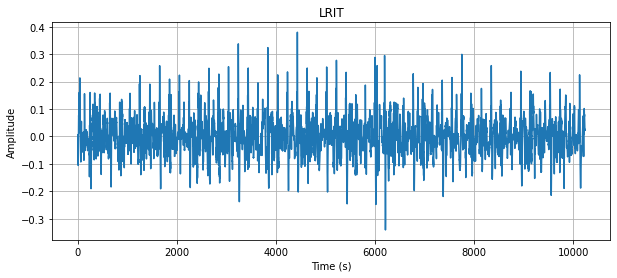

In [35]:
import librosa
import matplotlib.pyplot as plt

# Load audio file
audio_file = "D:/Data/호흡데이터/Task2/Wav_nonsegment/URTI, LRIT/188_1b1_Ar_sc_Meditron.wav"
waveform, sample_rate = librosa.load(audio_file)

# Get the duration of the audio in seconds
duration = len(waveform) / sample_rate

# Create the time axis for the waveform
time = librosa.times_like(waveform, sr=sample_rate)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time, waveform)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("LRIT")
plt.grid(True)
plt.show()

# spectrogram

In [16]:
# 폴더 경로 설정
folder_path = "D:/Data/호흡데이터/Task3/wav/both"

# 폴더 안에 있는 모든 .wav 파일의 경로 불러오기
wav_files = glob.glob(os.path.join(folder_path, "*.wav"))

# 스펙트로그램 이미지 저장 경로 설정
save_path = "D:/Data/호흡데이터/Task3/spectrogram/both/"

# 폴더 안에 있는 모든 .wav 파일에 대해 스펙트로그램 생성 및 이미지로 저장
for wav_file in wav_files:
    print(wav_file)
    # Load audio file
    y, sr = librosa.load(wav_file)

    # Create spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    # Convert to dB scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Visualize spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, y_axis='mel', fmax=8000, x_axis='time')
    plt.axis('off')
    plt.tight_layout()
    
    # .wav 파일 이름에서 앞 3자리 숫자 추출
    filename = os.path.splitext(os.path.basename(wav_file))[0]
    folder_name = filename[:3]  # 첫 3자리 숫자 추출
    
    # 폴더 생성
    folder_path = os.path.join(save_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    # 이미지 파일로 저장
    image_filename = filename + '.png'
    save_file_path = os.path.join(folder_path, image_filename)
    plt.savefig(save_file_path, bbox_inches='tight', pad_inches=0)
    
    plt.close()

D:/Data/호흡데이터/Task3/wav/both\107_2b3_Ar_mc_AKGC417L_cycle_10.53_13.196.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Ar_mc_AKGC417L_cycle_13.196_15.565.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Ar_mc_AKGC417L_cycle_15.565_18.054.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Ar_mc_AKGC417L_cycle_18.054_19.101.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Ar_mc_AKGC417L_cycle_2.601_5.327.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Ar_mc_AKGC417L_cycle_5.327_7.923.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Ar_mc_AKGC417L_cycle_7.923_10.53.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Pr_mc_AKGC417L_cycle_13.196_15.565.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Pr_mc_AKGC417L_cycle_18.054_19.101.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b3_Pr_mc_AKGC417L_cycle_5.327_7.923.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b4_Al_mc_AKGC417L_cycle_5.827_8.339.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b5_Ar_mc_AKGC417L_cycle_8.97_11.542.wav
D:/Data/호흡데이터/Task3/wav/both\107_2b5_Pr_mc_AKGC417L_cycle_16.625_19.339.wav
D:/Data/호흡데이터/Task3/wav/b

D:/Data/호흡데이터/Task3/wav/both\130_3p4_Al_mc_AKGC417L_cycle_2.697_5.47.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Pl_mc_AKGC417L_cycle_10.729_13.377.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Pl_mc_AKGC417L_cycle_5.47_7.995.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Pl_mc_AKGC417L_cycle_7.995_10.729.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Pr_mc_AKGC417L_cycle_0.066_2.697.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Pr_mc_AKGC417L_cycle_2.697_5.47.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Tc_mc_AKGC417L_cycle_0.066_2.697.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Tc_mc_AKGC417L_cycle_10.729_13.377.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Tc_mc_AKGC417L_cycle_2.697_5.47.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Tc_mc_AKGC417L_cycle_5.47_7.995.wav
D:/Data/호흡데이터/Task3/wav/both\130_3p4_Tc_mc_AKGC417L_cycle_7.995_10.729.wav
D:/Data/호흡데이터/Task3/wav/both\133_3p2_Pl_mc_AKGC417L_cycle_0.851_2.197.wav
D:/Data/호흡데이터/Task3/wav/both\133_3p2_Pr_mc_AKGC417L_cycle_14.744_17.173.wav
D:/Data/호흡데이터/Task3/wav/both\133_3p

D:/Data/호흡데이터/Task3/wav/both\156_5b3_Lr_mc_AKGC417L_cycle_8.437_10.552.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pl_mc_AKGC417L_cycle_0.016_2.035.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pl_mc_AKGC417L_cycle_10.552_12.773.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pl_mc_AKGC417L_cycle_15.089_17.263.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pl_mc_AKGC417L_cycle_2.035_4.208.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pl_mc_AKGC417L_cycle_4.208_6.435.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pl_mc_AKGC417L_cycle_6.435_8.437.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pl_mc_AKGC417L_cycle_8.437_10.552.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pr_mc_AKGC417L_cycle_0.016_2.035.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pr_mc_AKGC417L_cycle_10.552_12.773.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pr_mc_AKGC417L_cycle_12.773_15.089.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pr_mc_AKGC417L_cycle_15.089_17.263.wav
D:/Data/호흡데이터/Task3/wav/both\156_5b3_Pr_mc_AKGC417L_cycle_17.263_19.672.wav
D:/Data/호흡데이터/Task3/wav/

D:/Data/호흡데이터/Task3/wav/both\160_1b4_Al_mc_AKGC417L_cycle_11.16_15.401.wav
D:/Data/호흡데이터/Task3/wav/both\160_1b4_Al_mc_AKGC417L_cycle_15.401_19.841.wav
D:/Data/호흡데이터/Task3/wav/both\160_1b4_Al_mc_AKGC417L_cycle_6.553_11.16.wav
D:/Data/호흡데이터/Task3/wav/both\160_1b4_Ar_mc_AKGC417L_cycle_11.16_15.401.wav
D:/Data/호흡데이터/Task3/wav/both\160_1b4_Ar_mc_AKGC417L_cycle_15.401_19.841.wav
D:/Data/호흡데이터/Task3/wav/both\160_1b4_Pl_mc_AKGC417L_cycle_6.553_11.16.wav
D:/Data/호흡데이터/Task3/wav/both\160_1b4_Pr_mc_AKGC417L_cycle_1.962_6.553.wav
D:/Data/호흡데이터/Task3/wav/both\160_1b4_Pr_mc_AKGC417L_cycle_6.553_11.16.wav
D:/Data/호흡데이터/Task3/wav/both\161_1b1_Al_sc_Meditron_cycle_0.179_3.136.wav
D:/Data/호흡데이터/Task3/wav/both\161_1b1_Al_sc_Meditron_cycle_3.136_4.821.wav
D:/Data/호흡데이터/Task3/wav/both\162_1b2_Ar_mc_AKGC417L_cycle_3.481_10.793.wav
D:/Data/호흡데이터/Task3/wav/both\170_1b4_Ar_mc_AKGC417L_cycle_15.634_18.84.wav
D:/Data/호흡데이터/Task3/wav/both\170_1b4_Ar_mc_AKGC417L_cycle_3.214_6.219.wav
D:/Data/호흡데이터/Task3/wav/both\1

D:/Data/호흡데이터/Task3/wav/both\218_1b1_Ar_sc_Meditron_cycle_40.642_45.214.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Ar_sc_Meditron_cycle_45.214_50.503.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Ar_sc_Meditron_cycle_50.503_57.677.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Ar_sc_Meditron_cycle_57.677_65.28.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Ar_sc_Meditron_cycle_7.5347_11.202.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Lr_sc_Meditron_cycle_52.521_56.589.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Lr_sc_Meditron_cycle_56.589_60.568.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Lr_sc_Meditron_cycle_60.568_65.012.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Lr_sc_Meditron_cycle_73.678_78.827.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Pl_sc_Meditron_cycle_32.523_37.166.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Pl_sc_Meditron_cycle_37.166_42.582.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Pl_sc_Meditron_cycle_42.582_47.436.wav
D:/Data/호흡데이터/Task3/wav/both\218_1b1_Pl_sc_Meditron_cycle_47.436_52.708.wav
D:/Data/호흡데이터

In [18]:
# 폴더 경로 설정
folder_path = "D:/Data/호흡데이터/Task3/wav/crack"

# 폴더 안에 있는 모든 .wav 파일의 경로 불러오기
wav_files = glob.glob(os.path.join(folder_path, "*.wav"))

# 스펙트로그램 이미지 저장 경로 설정
save_path = "D:/Data/호흡데이터/Task3/spectrogram/crack/"

# 폴더 안에 있는 모든 .wav 파일에 대해 스펙트로그램 생성 및 이미지로 저장
for wav_file in wav_files:
    print(wav_file)
    # Load audio file
    y, sr = librosa.load(wav_file)

    # Create spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    # Convert to dB scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Visualize spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, y_axis='mel', fmax=8000, x_axis='time')
    plt.axis('off')
    plt.tight_layout()
    
    # .wav 파일 이름에서 앞 3자리 숫자 추출
    filename = os.path.splitext(os.path.basename(wav_file))[0]
    folder_name = filename[:3]  # 첫 3자리 숫자 추출
    
    # 폴더 생성
    folder_path = os.path.join(save_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    # 이미지 파일로 저장
    image_filename = filename + '.png'
    save_file_path = os.path.join(folder_path, image_filename)
    plt.savefig(save_file_path, bbox_inches='tight', pad_inches=0)
    
    plt.close()

D:/Data/호흡데이터/Task3/wav/crack\104_1b1_Ll_sc_Litt3200_cycle_8.8287_10.396.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_0.036_2.164.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_12.007_14.407.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_14.407_16.793.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_16.793_19.207.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_19.207_19.964.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_2.164_4.621.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_7.179_9.636.wav
D:/Data/호흡데이터/Task3/wav/crack\106_2b1_Pl_mc_LittC2SE_cycle_9.636_12.007.wav
D:/Data/호흡데이터/Task3/wav/crack\107_2b3_Al_mc_AKGC417L_cycle_0.887_2.601.wav
D:/Data/호흡데이터/Task3/wav/crack\107_2b3_Al_mc_AKGC417L_cycle_10.53_13.196.wav
D:/Data/호흡데이터/Task3/wav/crack\107_2b3_Al_mc_AKGC417L_cycle_13.196_15.565.wav
D:/Data/호흡데이터/Task3/wav/crack\107_2b3_Al_mc_AKGC417L_cycle_15.565_18.054.wav
D:/Data/호

D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Al_mc_AKGC417L_cycle_14.47_16.696.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Al_mc_AKGC417L_cycle_16.696_18.887.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Al_mc_AKGC417L_cycle_18.887_19.792.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Al_mc_AKGC417L_cycle_7.851_10.054.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_0.804_3.256.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_10.054_12.066.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_12.066_14.47.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_14.47_16.696.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_16.696_18.887.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_18.887_19.792.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_3.256_5.566.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_5.566_7.851.wav
D:/Data/호흡데이터/Task3/wav/crack\107_3p2_Ll_mc_AKGC417L_cycle_7.851_10.054.wav
D:/Data/호흡

D:/Data/호흡데이터/Task3/wav/crack\130_1p2_Pl_mc_AKGC417L_cycle_8.339_11.28.wav
D:/Data/호흡데이터/Task3/wav/crack\130_1p2_Pr_mc_AKGC417L_cycle_2.423_5.101.wav
D:/Data/호흡데이터/Task3/wav/crack\130_1p2_Pr_mc_AKGC417L_cycle_8.339_11.28.wav
D:/Data/호흡데이터/Task3/wav/crack\130_1p2_Tc_mc_AKGC417L_cycle_0.697_2.423.wav
D:/Data/호흡데이터/Task3/wav/crack\130_1p2_Tc_mc_AKGC417L_cycle_2.423_5.101.wav
D:/Data/호흡데이터/Task3/wav/crack\130_1p2_Tc_mc_AKGC417L_cycle_8.339_11.28.wav
D:/Data/호흡데이터/Task3/wav/crack\130_1p3_Ar_mc_AKGC417L_cycle_18.375_19.946.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b2_Al_mc_AKGC417L_cycle_0.069_2.563.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b2_Al_mc_AKGC417L_cycle_10.124_12.707.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b2_Al_mc_AKGC417L_cycle_12.707_15.078.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b2_Al_mc_AKGC417L_cycle_15.078_17.615.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b2_Al_mc_AKGC417L_cycle_17.615_19.946.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b2_Al_mc_AKGC417L_cycle_2.563_4.933.wav
D:/Data/호흡데이터/T

D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Al_mc_AKGC417L_cycle_5.875_8.173.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Al_mc_AKGC417L_cycle_8.173_10.542.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_0.338_1.399.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_1.399_3.768.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_10.542_12.673.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_12.673_15.042.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_15.042_17.244.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_17.244_19.426.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_3.768_5.875.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_5.875_8.173.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ar_mc_AKGC417L_cycle_8.173_10.542.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ll_mc_AKGC417L_cycle_1.399_3.768.wav
D:/Data/호흡데이터/Task3/wav/crack\130_2b4_Ll_mc_AKGC417L_cycle_10.542_12.673.wav
D:/Data/호흡데이터

D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pl_mc_AKGC417L_cycle_14.079_17.703.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pl_mc_AKGC417L_cycle_17.703_19.167.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pl_mc_AKGC417L_cycle_5.925_9.958.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pl_mc_AKGC417L_cycle_9.958_14.079.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pr_mc_AKGC417L_cycle_1.414_5.925.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pr_mc_AKGC417L_cycle_14.079_17.703.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pr_mc_AKGC417L_cycle_17.703_19.167.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pr_mc_AKGC417L_cycle_5.925_9.958.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3b4_Pr_mc_AKGC417L_cycle_9.958_14.079.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3p2_Al_mc_AKGC417L_cycle_1.461_2.918.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3p2_Al_mc_AKGC417L_cycle_11.637_14.492.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3p2_Al_mc_AKGC417L_cycle_14.492_17.389.wav
D:/Data/호흡데이터/Task3/wav/crack\130_3p2_Al_mc_AKGC417L_cycle_17.389_18.796.wav
D:/Data/호

D:/Data/호흡데이터/Task3/wav/crack\133_2p2_Tc_mc_AKGC417L_cycle_12.256_14.542.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p2_Tc_mc_AKGC417L_cycle_5.018_7.387.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Pl_mc_AKGC417L_cycle_0.042_2.351.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Pl_mc_AKGC417L_cycle_12.542_15.232.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Pl_mc_AKGC417L_cycle_15.232_17.839.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Pl_mc_AKGC417L_cycle_2.351_4.911.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Pl_mc_AKGC417L_cycle_7.375_9.946.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Pl_mc_AKGC417L_cycle_9.946_12.542.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Pr_mc_AKGC417L_cycle_9.946_12.542.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Tc_mc_AKGC417L_cycle_15.232_17.839.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p3_Tc_mc_AKGC417L_cycle_9.946_12.542.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p4_Ar_mc_AKGC417L_cycle_1.066_3.554.wav
D:/Data/호흡데이터/Task3/wav/crack\133_2p4_Pl_mc_AKGC417L_cycle_1.066_3.554.wav
D:/Data/호흡데이터/

D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Lr_mc_AKGC417L_cycle_6.035_8.94.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Lr_mc_AKGC417L_cycle_8.94_11.828.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pl_mc_AKGC417L_cycle_1.644_3.18.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pl_mc_AKGC417L_cycle_11.828_14.449.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pl_mc_AKGC417L_cycle_14.449_17.654.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pl_mc_AKGC417L_cycle_3.18_6.035.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pl_mc_AKGC417L_cycle_6.035_8.94.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pl_mc_AKGC417L_cycle_8.94_11.828.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pr_mc_AKGC417L_cycle_1.644_3.18.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pr_mc_AKGC417L_cycle_11.828_14.449.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pr_mc_AKGC417L_cycle_14.449_17.654.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pr_mc_AKGC417L_cycle_3.18_6.035.wav
D:/Data/호흡데이터/Task3/wav/crack\138_2p2_Pr_mc_AKGC417L_cycle_8.94_11.828.wav
D:/Data/호흡데이터/Task3/wav

D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_0.399_2.327.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_11.554_13.089.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_13.089_14.566.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_14.566_16.101.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_16.101_17.613.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_2.327_4.316.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_4.316_6.149.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_6.149_8.042.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_8.042_9.816.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pl_mc_AKGC417L_cycle_9.816_11.554.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pr_mc_AKGC417L_cycle_0.399_2.327.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pr_mc_AKGC417L_cycle_16.101_17.613.wav
D:/Data/호흡데이터/Task3/wav/crack\154_1b3_Pr_mc_AKGC417L_cycle_17.613_19.089.wav
D:/Data/호흡데이

D:/Data/호흡데이터/Task3/wav/crack\156_5b3_Pl_mc_AKGC417L_cycle_17.263_19.672.wav
D:/Data/호흡데이터/Task3/wav/crack\156_8b3_Ar_mc_AKGC417L_cycle_1.935_4.185.wav
D:/Data/호흡데이터/Task3/wav/crack\156_8b3_Ll_mc_AKGC417L_cycle_1.935_4.185.wav
D:/Data/호흡데이터/Task3/wav/crack\156_8b3_Pl_mc_AKGC417L_cycle_1.935_4.185.wav
D:/Data/호흡데이터/Task3/wav/crack\156_8b3_Pl_mc_AKGC417L_cycle_13.185_15.423.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Al_sc_Meditron_cycle_35.945_40.048.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Al_sc_Meditron_cycle_50.372_53.53.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Lr_sc_Meditron_cycle_31.77_35.513.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Lr_sc_Meditron_cycle_35.513_40.19.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Lr_sc_Meditron_cycle_45.091_48.717.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Lr_sc_Meditron_cycle_48.717_52.063.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Lr_sc_Meditron_cycle_52.063_55.216.wav
D:/Data/호흡데이터/Task3/wav/crack\157_1b1_Lr_sc_Meditron_cycle_55.216_58.295.wav
D:/Data/

D:/Data/호흡데이터/Task3/wav/crack\163_2b2_Ll_mc_AKGC417L_cycle_8.553_13.257.wav
D:/Data/호흡데이터/Task3/wav/crack\163_2b2_Lr_mc_AKGC417L_cycle_0.025_3.765.wav
D:/Data/호흡데이터/Task3/wav/crack\163_2b2_Lr_mc_AKGC417L_cycle_13.257_17.369.wav
D:/Data/호흡데이터/Task3/wav/crack\163_2b2_Lr_mc_AKGC417L_cycle_8.553_13.257.wav
D:/Data/호흡데이터/Task3/wav/crack\163_2b2_Pl_mc_AKGC417L_cycle_0.025_3.765.wav
D:/Data/호흡데이터/Task3/wav/crack\163_2b2_Pl_mc_AKGC417L_cycle_3.765_8.553.wav
D:/Data/호흡데이터/Task3/wav/crack\164_1b1_Ll_sc_Meditron_cycle_3.85_6.693.wav
D:/Data/호흡데이터/Task3/wav/crack\165_1b1_Ar_sc_Meditron_cycle_3.704_6.933.wav
D:/Data/호흡데이터/Task3/wav/crack\165_1b1_Ar_sc_Meditron_cycle_6.933_10.545.wav
D:/Data/호흡데이터/Task3/wav/crack\165_1b1_Pr_sc_Meditron_cycle_2.279_4.879.wav
D:/Data/호흡데이터/Task3/wav/crack\166_1p1_Al_sc_Meditron_cycle_42.564_45.236.wav
D:/Data/호흡데이터/Task3/wav/crack\166_1p1_Al_sc_Meditron_cycle_45.236_48.199.wav
D:/Data/호흡데이터/Task3/wav/crack\166_1p1_Al_sc_Meditron_cycle_50.711_53.823.wav
D:/Data/호흡데이터/T

D:/Data/호흡데이터/Task3/wav/crack\172_2b5_Al_mc_AKGC417L_cycle_7.387_10.175.wav
D:/Data/호흡데이터/Task3/wav/crack\172_2b5_Lr_mc_AKGC417L_cycle_4.249_7.387.wav
D:/Data/호흡데이터/Task3/wav/crack\172_2b5_Pl_mc_AKGC417L_cycle_1.377_4.249.wav
D:/Data/호흡데이터/Task3/wav/crack\172_2b5_Pl_mc_AKGC417L_cycle_4.249_7.387.wav
D:/Data/호흡데이터/Task3/wav/crack\172_2b5_Pl_mc_AKGC417L_cycle_7.387_10.175.wav
D:/Data/호흡데이터/Task3/wav/crack\172_2b5_Pr_mc_AKGC417L_cycle_1.377_4.249.wav
D:/Data/호흡데이터/Task3/wav/crack\173_1b1_Al_sc_Meditron_cycle_11.291_13.213.wav
D:/Data/호흡데이터/Task3/wav/crack\173_1b1_Al_sc_Meditron_cycle_13.213_14.894.wav
D:/Data/호흡데이터/Task3/wav/crack\173_1b1_Al_sc_Meditron_cycle_14.894_16.383.wav
D:/Data/호흡데이터/Task3/wav/crack\173_1b1_Al_sc_Meditron_cycle_2.122_3.522.wav
D:/Data/호흡데이터/Task3/wav/crack\173_1b1_Al_sc_Meditron_cycle_5.921_7.793.wav
D:/Data/호흡데이터/Task3/wav/crack\174_1p2_Ar_mc_AKGC417L_cycle_7.17_11.027.wav
D:/Data/호흡데이터/Task3/wav/crack\174_1p2_Ll_mc_AKGC417L_cycle_11.027_15.351.wav
D:/Data/호흡데이터/T

D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Ll_mc_AKGC417L_cycle_13.423_17.291.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Ll_mc_AKGC417L_cycle_17.291_19.964.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Ll_mc_AKGC417L_cycle_2.13_6.245.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Ll_mc_AKGC417L_cycle_6.245_9.852.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Ll_mc_AKGC417L_cycle_9.852_13.423.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Lr_mc_AKGC417L_cycle_13.423_17.291.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Lr_mc_AKGC417L_cycle_17.291_19.964.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Lr_mc_AKGC417L_cycle_2.13_6.245.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Lr_mc_AKGC417L_cycle_6.245_9.852.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Lr_mc_AKGC417L_cycle_9.852_13.423.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Pl_mc_AKGC417L_cycle_13.423_17.291.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Pl_mc_AKGC417L_cycle_17.291_19.964.wav
D:/Data/호흡데이터/Task3/wav/crack\176_1b3_Pl_mc_AKGC417L_cycle_2.13_6.245.wav
D:/Data/호흡데이터/

D:/Data/호흡데이터/Task3/wav/crack\176_2b3_Tc_mc_AKGC417L_cycle_7.995_11.193.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Al_mc_AKGC417L_cycle_1.995_8.406.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Al_mc_AKGC417L_cycle_12.045_15.885.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Al_mc_AKGC417L_cycle_15.885_19.424.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Al_mc_AKGC417L_cycle_8.406_12.045.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Ar_mc_AKGC417L_cycle_1.995_8.406.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Ar_mc_AKGC417L_cycle_15.885_19.424.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Lr_mc_AKGC417L_cycle_1.995_8.406.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Lr_mc_AKGC417L_cycle_8.406_12.045.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Pl_mc_AKGC417L_cycle_1.995_8.406.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Pl_mc_AKGC417L_cycle_12.045_15.885.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Pl_mc_AKGC417L_cycle_15.885_19.424.wav
D:/Data/호흡데이터/Task3/wav/crack\177_1b2_Pl_mc_AKGC417L_cycle_8.406_12.045.wav
D:/Data/호흡데

D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Lr_mc_AKGC417L_cycle_1.351_5.292.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Lr_mc_AKGC417L_cycle_13.006_17.125.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Lr_mc_AKGC417L_cycle_17.125_18.458.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Lr_mc_AKGC417L_cycle_5.292_9.423.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Lr_mc_AKGC417L_cycle_9.423_13.006.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pl_mc_AKGC417L_cycle_1.351_5.292.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pl_mc_AKGC417L_cycle_13.006_17.125.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pl_mc_AKGC417L_cycle_17.125_18.458.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pl_mc_AKGC417L_cycle_5.292_9.423.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pl_mc_AKGC417L_cycle_9.423_13.006.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pr_mc_AKGC417L_cycle_1.351_5.292.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pr_mc_AKGC417L_cycle_13.006_17.125.wav
D:/Data/호흡데이터/Task3/wav/crack\186_2b2_Pr_mc_AKGC417L_cycle_17.125_18.458.wav
D:/Data/호흡데

D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Ar_mc_AKGC417L_cycle_16.98_19.907.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Ar_mc_AKGC417L_cycle_3.596_6.963.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Ar_mc_AKGC417L_cycle_6.963_10.347.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Ll_mc_AKGC417L_cycle_1.868_5.216.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Lr_mc_AKGC417L_cycle_0.042_1.243.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Lr_mc_AKGC417L_cycle_1.243_4.049.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Lr_mc_AKGC417L_cycle_10.254_13.466.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Lr_mc_AKGC417L_cycle_13.466_16.948.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Lr_mc_AKGC417L_cycle_16.948_19.535.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Lr_mc_AKGC417L_cycle_4.049_6.94.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Lr_mc_AKGC417L_cycle_6.94_10.254.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Pl_mc_AKGC417L_cycle_0.025_1.851.wav
D:/Data/호흡데이터/Task3/wav/crack\198_6p1_Pl_mc_AKGC417L_cycle_1.851_4.776.wav
D:/Data/호흡데이터/Task

D:/Data/호흡데이터/Task3/wav/crack\203_1p3_Pr_mc_AKGC417L_cycle_12.03_13.982.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p3_Pr_mc_AKGC417L_cycle_16.054_18.232.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p3_Pr_mc_AKGC417L_cycle_18.232_19.958.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p3_Pr_mc_AKGC417L_cycle_4.077_5.982.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Al_mc_AKGC417L_cycle_2.208_4.577.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Al_mc_AKGC417L_cycle_4.577_6.97.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Al_mc_AKGC417L_cycle_6.97_9.351.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Ar_mc_AKGC417L_cycle_11.851_14.244.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Ar_mc_AKGC417L_cycle_14.244_16.744.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Ar_mc_AKGC417L_cycle_19.125_19.97.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Ar_mc_AKGC417L_cycle_2.208_4.577.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Ar_mc_AKGC417L_cycle_4.577_6.97.wav
D:/Data/호흡데이터/Task3/wav/crack\203_1p4_Ar_mc_AKGC417L_cycle_6.97_9.351.wav
D:/Data/호흡데이터/Task3

D:/Data/호흡데이터/Task3/wav/crack\207_2b4_Pl_mc_AKGC417L_cycle_8.556_12.396.wav
D:/Data/호흡데이터/Task3/wav/crack\207_2b4_Pr_mc_AKGC417L_cycle_1.261_4.583.wav
D:/Data/호흡데이터/Task3/wav/crack\207_2b4_Pr_mc_AKGC417L_cycle_4.583_8.556.wav
D:/Data/호흡데이터/Task3/wav/crack\207_2b4_Pr_mc_AKGC417L_cycle_8.556_12.396.wav
D:/Data/호흡데이터/Task3/wav/crack\210_1b1_Al_sc_Meditron_cycle_9.693_10.879.wav
D:/Data/호흡데이터/Task3/wav/crack\210_1b1_Ar_sc_Meditron_cycle_8.926_11.333.wav
D:/Data/호흡데이터/Task3/wav/crack\211_1p2_Pl_mc_AKGC417L_cycle_17.024_18.751.wav
D:/Data/호흡데이터/Task3/wav/crack\211_1p2_Pl_mc_AKGC417L_cycle_18.751_19.656.wav
D:/Data/호흡데이터/Task3/wav/crack\211_1p2_Pl_mc_AKGC417L_cycle_4.904_6.446.wav
D:/Data/호흡데이터/Task3/wav/crack\211_1p2_Pl_mc_AKGC417L_cycle_6.446_8.005.wav
D:/Data/호흡데이터/Task3/wav/crack\211_1p2_Pl_mc_AKGC417L_cycle_9.648_11.09.wav
D:/Data/호흡데이터/Task3/wav/crack\212_2b2_Tc_mc_LittC2SE_cycle_1.379_4.936.wav
D:/Data/호흡데이터/Task3/wav/crack\212_2b2_Tc_mc_LittC2SE_cycle_7.964_11.736.wav
D:/Data/호흡데이터/Ta

D:/Data/호흡데이터/Task3/wav/crack\226_1b1_Ll_sc_Meditron_cycle_5.893_7.85.wav
D:/Data/호흡데이터/Task3/wav/crack\226_1b1_Ll_sc_Meditron_cycle_9.864_11.779.wav
D:/Data/호흡데이터/Task3/wav/crack\226_1b1_Pl_sc_LittC2SE_cycle_11.721_13.693.wav
D:/Data/호흡데이터/Task3/wav/crack\226_1b1_Pl_sc_LittC2SE_cycle_17.493_19.436.wav
D:/Data/호흡데이터/Task3/wav/crack\226_1b1_Pl_sc_LittC2SE_cycle_3.55_5.75.wav
D:/Data/호흡데이터/Task3/wav/crack\226_1b1_Pl_sc_LittC2SE_cycle_5.75_7.879.wav
D:/Data/호흡데이터/Task3/wav/crack\226_1b1_Pl_sc_LittC2SE_cycle_9.836_11.721.wav


In [19]:
# 폴더 경로 설정
folder_path = "D:/Data/호흡데이터/Task3/wav/wheezes"

# 폴더 안에 있는 모든 .wav 파일의 경로 불러오기
wav_files = glob.glob(os.path.join(folder_path, "*.wav"))

# 스펙트로그램 이미지 저장 경로 설정
save_path = "D:/Data/호흡데이터/Task3/spectrogram/wheezes/"

# 폴더 안에 있는 모든 .wav 파일에 대해 스펙트로그램 생성 및 이미지로 저장
for wav_file in wav_files:
    print(wav_file)
    # Load audio file
    y, sr = librosa.load(wav_file)

    # Create spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    # Convert to dB scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Visualize spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, y_axis='mel', fmax=8000, x_axis='time')
    plt.axis('off')
    plt.tight_layout()
    
    # .wav 파일 이름에서 앞 3자리 숫자 추출
    filename = os.path.splitext(os.path.basename(wav_file))[0]
    folder_name = filename[:3]  # 첫 3자리 숫자 추출
    
    # 폴더 생성
    folder_path = os.path.join(save_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    # 이미지 파일로 저장
    image_filename = filename + '.png'
    save_file_path = os.path.join(folder_path, image_filename)
    plt.savefig(save_file_path, bbox_inches='tight', pad_inches=0)
    
    plt.close()

D:/Data/호흡데이터/Task3/wav/wheezes\103_2b2_Ar_mc_LittC2SE_cycle_0.364_3.25.wav
D:/Data/호흡데이터/Task3/wav/wheezes\103_2b2_Ar_mc_LittC2SE_cycle_11.179_14.25.wav
D:/Data/호흡데이터/Task3/wav/wheezes\103_2b2_Ar_mc_LittC2SE_cycle_14.25_16.993.wav
D:/Data/호흡데이터/Task3/wav/wheezes\103_2b2_Ar_mc_LittC2SE_cycle_6.636_11.179.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_0.0_0.54469.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_0.54469_2.9628.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_10.675_12.371.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_12.371_14.381.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_14.381_16.535.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_16.535_19.048.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_2.9628_5.1085.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycle_5.1085_7.2172.wav
D:/Data/호흡데이터/Task3/wav/wheezes\104_1b1_Ar_sc_Litt3200_cycl

D:/Data/호흡데이터/Task3/wav/wheezes\122_2b2_Tc_mc_LittC2SE_cycle_15.864_19.964.wav
D:/Data/호흡데이터/Task3/wav/wheezes\122_2b2_Tc_mc_LittC2SE_cycle_4.421_8.236.wav
D:/Data/호흡데이터/Task3/wav/wheezes\122_2b2_Tc_mc_LittC2SE_cycle_8.236_12.064.wav
D:/Data/호흡데이터/Task3/wav/wheezes\122_2b3_Al_mc_LittC2SE_cycle_4.15_7.95.wav
D:/Data/호흡데이터/Task3/wav/wheezes\122_2b3_Ar_mc_LittC2SE_cycle_4.207_7.893.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Al_sc_Litt3200_cycle_1.8954_3.2007.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Al_sc_Litt3200_cycle_3.2007_4.5909.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Al_sc_Litt3200_cycle_4.5909_5.8841.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Al_sc_Litt3200_cycle_5.8841_7.2258.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Al_sc_Litt3200_cycle_7.2258_8.4867.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Al_sc_Litt3200_cycle_8.4867_9.6466.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Ar_sc_Litt3200_cycle_0.71479_2.0065.wav
D:/Data/호흡데이터/Task3/wav/wheezes\124_1b1_Ar_sc_Litt3200_cycle

D:/Data/호흡데이터/Task3/wav/wheezes\133_3p4_Tc_mc_AKGC417L_cycle_0.756_3.077.wav
D:/Data/호흡데이터/Task3/wav/wheezes\133_3p4_Tc_mc_AKGC417L_cycle_10.744_13.137.wav
D:/Data/호흡데이터/Task3/wav/wheezes\133_3p4_Tc_mc_AKGC417L_cycle_13.137_15.72.wav
D:/Data/호흡데이터/Task3/wav/wheezes\133_3p4_Tc_mc_AKGC417L_cycle_15.72_18.315.wav
D:/Data/호흡데이터/Task3/wav/wheezes\133_3p4_Tc_mc_AKGC417L_cycle_5.673_8.161.wav
D:/Data/호흡데이터/Task3/wav/wheezes\133_3p4_Tc_mc_AKGC417L_cycle_8.161_10.744.wav
D:/Data/호흡데이터/Task3/wav/wheezes\134_2b3_Ar_mc_LittC2SE_cycle_9.007_12.864.wav
D:/Data/호흡데이터/Task3/wav/wheezes\138_1p2_Al_mc_AKGC417L_cycle_0.159_3.715.wav
D:/Data/호흡데이터/Task3/wav/wheezes\138_1p2_Tc_mc_AKGC417L_cycle_11.461_15.568.wav
D:/Data/호흡데이터/Task3/wav/wheezes\138_1p3_Pl_mc_AKGC417L_cycle_0.109_2.529.wav
D:/Data/호흡데이터/Task3/wav/wheezes\138_1p3_Tc_mc_AKGC417L_cycle_2.529_6.786.wav
D:/Data/호흡데이터/Task3/wav/wheezes\139_1b1_Pl_sc_Litt3200_cycle_0.0_1.8055.wav
D:/Data/호흡데이터/Task3/wav/wheezes\139_1b1_Pl_sc_Litt3200_cycle_1.8055_3

D:/Data/호흡데이터/Task3/wav/wheezes\151_2p2_Pl_mc_AKGC417L_cycle_0.609_2.412.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p2_Pl_mc_AKGC417L_cycle_15.701_19.157.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p2_Pl_mc_AKGC417L_cycle_2.412_5.601.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p2_Pl_mc_AKGC417L_cycle_5.601_8.74.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p2_Pr_mc_AKGC417L_cycle_0.609_2.412.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p2_Tc_mc_AKGC417L_cycle_15.701_19.157.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p2_Tc_mc_AKGC417L_cycle_2.412_5.601.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p3_Al_mc_AKGC417L_cycle_9.124_12.529.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p3_Ar_mc_AKGC417L_cycle_0.81_2.513.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p3_Ar_mc_AKGC417L_cycle_5.634_9.124.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p3_Ll_mc_AKGC417L_cycle_0.81_2.513.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p3_Ll_mc_AKGC417L_cycle_2.513_5.634.wav
D:/Data/호흡데이터/Task3/wav/wheezes\151_2p3_Ll_mc_AKGC417L_cycle_5.634_9.124.w

D:/Data/호흡데이터/Task3/wav/wheezes\159_1b1_Al_sc_Meditron_cycle_2.85_4.693.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b2_Ar_mc_AKGC417L_cycle_0.109_4.766.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b2_Ar_mc_AKGC417L_cycle_4.766_10.342.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b2_Lr_mc_AKGC417L_cycle_4.766_10.342.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b2_Pl_mc_AKGC417L_cycle_0.109_4.766.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b2_Pl_mc_AKGC417L_cycle_4.766_10.342.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b2_Pr_mc_AKGC417L_cycle_4.766_10.342.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b2_Tc_mc_AKGC417L_cycle_4.766_10.342.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b3_Al_mc_AKGC417L_cycle_1.862_5.718.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b3_Al_mc_AKGC417L_cycle_13.614_17.671.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b3_Al_mc_AKGC417L_cycle_9.725_13.614.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b3_Ar_mc_AKGC417L_cycle_1.862_5.718.wav
D:/Data/호흡데이터/Task3/wav/wheezes\160_1b3_Ar_mc_AKGC417L_cycle_13.614_1

D:/Data/호흡데이터/Task3/wav/wheezes\175_1b1_Pl_sc_Litt3200_cycle_12.463_21.68.wav
D:/Data/호흡데이터/Task3/wav/wheezes\175_1b1_Pl_sc_Litt3200_cycle_2.154_5.1193.wav
D:/Data/호흡데이터/Task3/wav/wheezes\175_1b1_Pl_sc_Litt3200_cycle_5.1193_8.8818.wav
D:/Data/호흡데이터/Task3/wav/wheezes\175_1b1_Pl_sc_Litt3200_cycle_8.8818_12.463.wav
D:/Data/호흡데이터/Task3/wav/wheezes\175_1b1_Pr_sc_Litt3200_cycle_11.181_16.752.wav
D:/Data/호흡데이터/Task3/wav/wheezes\175_1b1_Pr_sc_Litt3200_cycle_2.221_5.6038.wav
D:/Data/호흡데이터/Task3/wav/wheezes\175_1b1_Pr_sc_Litt3200_cycle_5.6038_11.181.wav
D:/Data/호흡데이터/Task3/wav/wheezes\177_1b2_Pr_mc_AKGC417L_cycle_12.045_15.885.wav
D:/Data/호흡데이터/Task3/wav/wheezes\177_1b2_Pr_mc_AKGC417L_cycle_15.885_19.424.wav
D:/Data/호흡데이터/Task3/wav/wheezes\177_1b2_Pr_mc_AKGC417L_cycle_8.406_12.045.wav
D:/Data/호흡데이터/Task3/wav/wheezes\177_1b4_Pr_mc_AKGC417L_cycle_0.359_3.364.wav
D:/Data/호흡데이터/Task3/wav/wheezes\177_1b4_Pr_mc_AKGC417L_cycle_11.043_14.583.wav
D:/Data/호흡데이터/Task3/wav/wheezes\177_1b4_Pr_mc_AKGC417L_cyc

D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Ar_mc_AKGC417L_cycle_2.901_4.523.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Ar_mc_AKGC417L_cycle_4.523_6.229.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Ar_mc_AKGC417L_cycle_6.229_7.901.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Ar_mc_AKGC417L_cycle_7.901_9.507.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Ar_mc_AKGC417L_cycle_9.507_11.162.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_0.364_1.263.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_1.263_2.901.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_11.162_12.918.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_12.918_14.64.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_14.64_16.447.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_16.447_18.119.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_18.119_19.908.wav
D:/Data/호흡데이터/Task3/wav/wheezes\193_1b2_Pl_mc_AKGC417L_cycle_2.901_

D:/Data/호흡데이터/Task3/wav/wheezes\198_1b5_Tc_mc_AKGC417L_cycle_0.042_2.293.wav
D:/Data/호흡데이터/Task3/wav/wheezes\198_1b5_Tc_mc_AKGC417L_cycle_12.394_15.541.wav
D:/Data/호흡데이터/Task3/wav/wheezes\198_1b5_Tc_mc_AKGC417L_cycle_15.541_18.875.wav
D:/Data/호흡데이터/Task3/wav/wheezes\198_1b5_Tc_mc_AKGC417L_cycle_2.293_5.44.wav
D:/Data/호흡데이터/Task3/wav/wheezes\198_1b5_Tc_mc_AKGC417L_cycle_5.44_8.976.wav
D:/Data/호흡데이터/Task3/wav/wheezes\198_1b5_Tc_mc_AKGC417L_cycle_8.976_12.394.wav
D:/Data/호흡데이터/Task3/wav/wheezes\201_1b1_Al_sc_Meditron_cycle_15.036_18.293.wav
D:/Data/호흡데이터/Task3/wav/wheezes\201_1b1_Al_sc_Meditron_cycle_5.122_8.407.wav
D:/Data/호흡데이터/Task3/wav/wheezes\201_1b1_Ar_sc_Meditron_cycle_0.893_4.093.wav
D:/Data/호흡데이터/Task3/wav/wheezes\201_1b1_Ar_sc_Meditron_cycle_10.364_13.707.wav
D:/Data/호흡데이터/Task3/wav/wheezes\201_1b1_Ar_sc_Meditron_cycle_13.707_17.107.wav
D:/Data/호흡데이터/Task3/wav/wheezes\201_1b1_Ar_sc_Meditron_cycle_17.107_19.95.wav
D:/Data/호흡데이터/Task3/wav/wheezes\201_1b1_Ar_sc_Meditron_cycle_4.093

D:/Data/호흡데이터/Task3/wav/wheezes\221_2b2_Pl_mc_LittC2SE_cycle_14.307_19.507.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b2_Pl_mc_LittC2SE_cycle_5.536_9.907.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b2_Pl_mc_LittC2SE_cycle_9.907_14.307.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Al_mc_LittC2SE_cycle_0.064_2.536.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Al_mc_LittC2SE_cycle_11.621_16.764.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Al_mc_LittC2SE_cycle_16.764_19.979.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Al_mc_LittC2SE_cycle_2.536_6.764.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Al_mc_LittC2SE_cycle_6.764_11.621.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Ar_mc_LittC2SE_cycle_0.107_2.55.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Lr_mc_LittC2SE_cycle_0.136_2.664.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Pr_mc_LittC2SE_cycle_0.064_2.779.wav
D:/Data/호흡데이터/Task3/wav/wheezes\221_2b3_Pr_mc_LittC2SE_cycle_2.779_7.05.wav
D:/Data/호흡데이터/Task3/wav/wheezes\222_1b1_Pr_sc_Meditron_cycle_40.124_47

In [20]:
# 폴더 경로 설정
folder_path = "D:/Data/호흡데이터/Task3/wav/normal"

# 폴더 안에 있는 모든 .wav 파일의 경로 불러오기
wav_files = glob.glob(os.path.join(folder_path, "*.wav"))

# 스펙트로그램 이미지 저장 경로 설정
save_path = "D:/Data/호흡데이터/Task3/spectrogram/normal/"

# 폴더 안에 있는 모든 .wav 파일에 대해 스펙트로그램 생성 및 이미지로 저장
for wav_file in wav_files:
    print(wav_file)
    # Load audio file
    y, sr = librosa.load(wav_file)

    # Create spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    # Convert to dB scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Visualize spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, y_axis='mel', fmax=8000, x_axis='time')
    plt.axis('off')
    plt.tight_layout()
    
    # .wav 파일 이름에서 앞 3자리 숫자 추출
    filename = os.path.splitext(os.path.basename(wav_file))[0]
    folder_name = filename[:3]  # 첫 3자리 숫자 추출
    
    # 폴더 생성
    folder_path = os.path.join(save_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    # 이미지 파일로 저장
    image_filename = filename + '.png'
    save_file_path = os.path.join(folder_path, image_filename)
    plt.savefig(save_file_path, bbox_inches='tight', pad_inches=0)
    
    plt.close()

D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_0.036_0.579.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_0.579_2.45.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_11.15_13.036.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_13.036_14.721.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_14.721_16.707.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_16.707_18.507.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_18.507_19.964.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_2.45_3.893.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_3.893_5.793.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_5.793_7.521.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_7.521_9.279.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Al_sc_Meditron_cycle_9.279_11.15.wav
D:/Data/호흡데이터/Task3/wav/normal\101_1b1_Pr_sc_Meditron_cycle_0.036_1.264.wav
D:/Da

D:/Data/호흡데이터/Task3/wav/normal\107_2b3_Tc_mc_AKGC417L_cycle_2.601_5.327.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b3_Tc_mc_AKGC417L_cycle_5.327_7.923.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Pl_mc_AKGC417L_cycle_10.923_13.292.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Pl_mc_AKGC417L_cycle_16.018_18.482.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Pl_mc_AKGC417L_cycle_18.482_19.542.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Pl_mc_AKGC417L_cycle_3.411_5.827.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Pl_mc_AKGC417L_cycle_8.339_10.923.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Tc_mc_AKGC417L_cycle_1.018_3.411.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Tc_mc_AKGC417L_cycle_10.923_13.292.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Tc_mc_AKGC417L_cycle_13.292_16.018.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Tc_mc_AKGC417L_cycle_16.018_18.482.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Tc_mc_AKGC417L_cycle_18.482_19.542.wav
D:/Data/호흡데이터/Task3/wav/normal\107_2b4_Tc_mc_AKGC417L_cycle_3.411_5.827.w

D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Ll_sc_Meditron_cycle_11.667_15.441.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Ll_sc_Meditron_cycle_15.441_19.678.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Ll_sc_Meditron_cycle_23.855_28.052.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Ll_sc_Meditron_cycle_28.052_32.4.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_0.91028_6.4933.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_10.911_14.176.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_14.176_18.291.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_18.291_23.497.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_23.497_28.134.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_28.134_34.797.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_34.797_40.599.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_40.599_45.696.wav
D:/Data/호흡데이터/Task3/wav/normal\110_1p1_Pr_sc_Meditron_cycle_45.69

D:/Data/호흡데이터/Task3/wav/normal\113_1b1_Pr_sc_Litt3200_cycle_3.0144_4.7622.wav
D:/Data/호흡데이터/Task3/wav/normal\113_1b1_Pr_sc_Litt3200_cycle_4.7622_6.7789.wav
D:/Data/호흡데이터/Task3/wav/normal\113_1b1_Pr_sc_Litt3200_cycle_6.7789_8.9301.wav
D:/Data/호흡데이터/Task3/wav/normal\113_1b1_Pr_sc_Litt3200_cycle_8.9301_10.975.wav
D:/Data/호흡데이터/Task3/wav/normal\114_1b4_Ar_mc_AKGC417L_cycle_19.006_19.958.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_0.064_0.393.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_0.393_1.236.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_1.236_2.193.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_10.836_12.179.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_12.179_13.007.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_13.007_13.65.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_13.65_14.593.wav
D:/Data/호흡데이터/Task3/wav/normal\115_1b1_Ar_sc_Meditron_cycle_14.593_15.47

D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_12.27_14.508.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_14.508_16.308.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_16.308_18.185.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_18.185_20.167.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_20.167_22.266.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_22.266_24.004.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_24.004_26.152.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_26.152_27.98.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_27.98_30.26.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_3.6079_5.6656.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_30.26_33.131.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_33.131_35.606.wav
D:/Data/호흡데이터/Task3/wav/normal\120_1b1_Lr_sc_Meditron_cycle_35.606_37

D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Al_mc_LittC2SE_cycle_7.95_12.321.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Ar_mc_LittC2SE_cycle_0.036_4.207.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Ar_mc_LittC2SE_cycle_12.221_16.593.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Ar_mc_LittC2SE_cycle_16.593_19.95.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Ar_mc_LittC2SE_cycle_7.893_12.221.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Tc_mc_LittC2SE_cycle_0.036_4.079.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Tc_mc_LittC2SE_cycle_12.321_16.607.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Tc_mc_LittC2SE_cycle_16.607_19.993.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Tc_mc_LittC2SE_cycle_4.079_7.95.wav
D:/Data/호흡데이터/Task3/wav/normal\122_2b3_Tc_mc_LittC2SE_cycle_7.95_12.321.wav
D:/Data/호흡데이터/Task3/wav/normal\123_1b1_Al_sc_Meditron_cycle_0.45_2.979.wav
D:/Data/호흡데이터/Task3/wav/normal\123_1b1_Al_sc_Meditron_cycle_10.779_14.279.wav
D:/Data/호흡데이터/Task3/wav/normal\123_1b1_Al_sc_Meditron_cycle_14.279_16.779.wav
D:

D:/Data/호흡데이터/Task3/wav/normal\130_1p4_Tc_mc_AKGC417L_cycle_15.923_18.518.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Ar_mc_AKGC417L_cycle_10.124_12.707.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Ar_mc_AKGC417L_cycle_12.707_15.078.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_0.069_2.563.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_10.124_12.707.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_12.707_15.078.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_15.078_17.615.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_17.615_19.946.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_2.563_4.933.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_4.933_7.466.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b2_Tc_mc_AKGC417L_cycle_7.466_10.124.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b3_Al_mc_AKGC417L_cycle_0.689_1.732.wav
D:/Data/호흡데이터/Task3/wav/normal\130_2b3_Ar_mc_AKGC417L_cycle_0.689_1.732.w

D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Pr_mc_AKGC417L_cycle_17.839_19.982.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Pr_mc_AKGC417L_cycle_2.351_4.911.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Pr_mc_AKGC417L_cycle_4.911_7.375.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Pr_mc_AKGC417L_cycle_7.375_9.946.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Tc_mc_AKGC417L_cycle_0.042_2.351.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Tc_mc_AKGC417L_cycle_12.542_15.232.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Tc_mc_AKGC417L_cycle_17.839_19.982.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Tc_mc_AKGC417L_cycle_2.351_4.911.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Tc_mc_AKGC417L_cycle_4.911_7.375.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p3_Tc_mc_AKGC417L_cycle_7.375_9.946.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p4_Al_mc_AKGC417L_cycle_1.066_3.554.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p4_Al_mc_AKGC417L_cycle_10.78_13.161.wav
D:/Data/호흡데이터/Task3/wav/normal\133_2p4_Al_mc_AKGC417L_cycle_18.292_19.47.wav
D:/D

D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Al_mc_LittC2SE_cycle_19.179_19.964.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Al_mc_LittC2SE_cycle_2.064_4.707.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Al_mc_LittC2SE_cycle_4.707_7.536.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Al_mc_LittC2SE_cycle_7.536_10.35.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_0.036_1.936.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_1.936_4.664.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_10.35_13.279.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_13.279_16.521.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_16.521_19.164.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_19.164_19.964.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_4.664_7.521.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Ar_mc_LittC2SE_cycle_7.521_10.35.wav
D:/Data/호흡데이터/Task3/wav/normal\135_2b2_Pl_mc_LittC2SE_cycle_0.022_4.85.wav
D:/D

D:/Data/호흡데이터/Task3/wav/normal\138_1p3_Al_mc_AKGC417L_cycle_2.529_6.786.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p3_Al_mc_AKGC417L_cycle_6.786_10.826.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p3_Tc_mc_AKGC417L_cycle_10.826_14.967.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p3_Tc_mc_AKGC417L_cycle_14.967_18.723.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Ar_mc_AKGC417L_cycle_16.886_18.773.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Ll_mc_AKGC417L_cycle_12.947_16.886.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Pl_mc_AKGC417L_cycle_16.886_18.773.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Tc_mc_AKGC417L_cycle_1.361_5.267.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Tc_mc_AKGC417L_cycle_12.947_16.886.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Tc_mc_AKGC417L_cycle_16.886_18.773.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Tc_mc_AKGC417L_cycle_5.267_9.224.wav
D:/Data/호흡데이터/Task3/wav/normal\138_1p4_Tc_mc_AKGC417L_cycle_9.224_12.947.wav
D:/Data/호흡데이터/Task3/wav/normal\138_2p2_Ar_mc_AKGC417L_cycle_1.644_3.18.w

D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_13.907_15.164.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_15.164_16.293.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_16.293_17.25.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_17.25_18.35.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_18.35_19.664.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_19.664_19.979.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_3.279_4.721.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_4.721_5.964.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_5.964_7.179.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_7.179_8.764.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_8.764_9.707.wav
D:/Data/호흡데이터/Task3/wav/normal\143_1b1_Al_sc_Meditron_cycle_9.707_10.621.wav
D:/Data/호흡데이터/Task3/wav/normal\144_1b1_Al_sc_Meditron_cycle_0.15_2.747.wav
D:/D

D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pl_mc_AKGC417L_cycle_14.054_16.542.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pl_mc_AKGC417L_cycle_16.542_19.03.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pl_mc_AKGC417L_cycle_19.03_19.946.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pl_mc_AKGC417L_cycle_3.899_6.518.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pl_mc_AKGC417L_cycle_6.518_9.006.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pl_mc_AKGC417L_cycle_9.006_11.446.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pr_mc_AKGC417L_cycle_0.042_1.197.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pr_mc_AKGC417L_cycle_1.197_3.863.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pr_mc_AKGC417L_cycle_11.28_13.827.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pr_mc_AKGC417L_cycle_13.827_16.446.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pr_mc_AKGC417L_cycle_16.446_19.03.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pr_mc_AKGC417L_cycle_19.03_19.97.wav
D:/Data/호흡데이터/Task3/wav/normal\146_8p3_Pr_mc_AKGC417L_cycle_3.863_6.47.wav
D:/D

D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Lr_sc_Meditron_cycle_3.722_4.564.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Lr_sc_Meditron_cycle_4.564_5.564.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Lr_sc_Meditron_cycle_5.564_6.507.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Lr_sc_Meditron_cycle_6.507_7.15.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Lr_sc_Meditron_cycle_7.15_7.793.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Lr_sc_Meditron_cycle_7.793_8.664.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Pl_sc_Meditron_cycle_0.25_1.207.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Pl_sc_Meditron_cycle_1.207_2.136.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Pl_sc_Meditron_cycle_12.45_13.636.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Pl_sc_Meditron_cycle_13.636_14.664.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Pl_sc_Meditron_cycle_14.664_16.19.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Pl_sc_Meditron_cycle_16.19_17.144.wav
D:/Data/호흡데이터/Task3/wav/normal\149_1b1_Pl_sc_Meditron_cycle_17.144_18.114.wav
D:/Data/

D:/Data/호흡데이터/Task3/wav/normal\153_1b1_Al_sc_Meditron_cycle_11.279_13.307.wav
D:/Data/호흡데이터/Task3/wav/normal\153_1b1_Al_sc_Meditron_cycle_13.307_17.264.wav
D:/Data/호흡데이터/Task3/wav/normal\153_1b1_Al_sc_Meditron_cycle_17.264_18.964.wav
D:/Data/호흡데이터/Task3/wav/normal\153_1b1_Al_sc_Meditron_cycle_18.964_19.65.wav
D:/Data/호흡데이터/Task3/wav/normal\153_1b1_Al_sc_Meditron_cycle_3.722_5.964.wav
D:/Data/호흡데이터/Task3/wav/normal\153_1b1_Al_sc_Meditron_cycle_5.964_8.507.wav
D:/Data/호흡데이터/Task3/wav/normal\153_1b1_Al_sc_Meditron_cycle_8.507_11.279.wav
D:/Data/호흡데이터/Task3/wav/normal\154_1b3_Al_mc_AKGC417L_cycle_14.566_16.101.wav
D:/Data/호흡데이터/Task3/wav/normal\154_1b3_Al_mc_AKGC417L_cycle_8.042_9.816.wav
D:/Data/호흡데이터/Task3/wav/normal\154_1b3_Al_mc_AKGC417L_cycle_9.816_11.554.wav
D:/Data/호흡데이터/Task3/wav/normal\154_1b3_Ar_mc_AKGC417L_cycle_0.399_2.327.wav
D:/Data/호흡데이터/Task3/wav/normal\154_1b3_Ar_mc_AKGC417L_cycle_11.554_13.089.wav
D:/Data/호흡데이터/Task3/wav/normal\154_1b3_Ar_mc_AKGC417L_cycle_13.089_14.566.w

D:/Data/호흡데이터/Task3/wav/normal\156_2b3_Ar_mc_AKGC417L_cycle_11.57_14.535.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Al_mc_AKGC417L_cycle_1.935_4.185.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Ar_mc_AKGC417L_cycle_13.185_15.423.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Lr_mc_AKGC417L_cycle_1.935_4.185.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Lr_mc_AKGC417L_cycle_10.839_13.185.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Lr_mc_AKGC417L_cycle_13.185_15.423.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Lr_mc_AKGC417L_cycle_15.423_17.613.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Lr_mc_AKGC417L_cycle_4.185_6.566.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Lr_mc_AKGC417L_cycle_6.566_8.601.wav
D:/Data/호흡데이터/Task3/wav/normal\156_8b3_Lr_mc_AKGC417L_cycle_8.601_10.839.wav
D:/Data/호흡데이터/Task3/wav/normal\157_1b1_Al_sc_Meditron_cycle_1.5003_5.9804.wav
D:/Data/호흡데이터/Task3/wav/normal\157_1b1_Al_sc_Meditron_cycle_13.136_19.358.wav
D:/Data/호흡데이터/Task3/wav/normal\157_1b1_Al_sc_Meditron_cycle_19.358_23.03.w

D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Al_sc_Meditron_cycle_6.493_8.079.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Al_sc_Meditron_cycle_8.079_9.607.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Al_sc_Meditron_cycle_9.607_11.421.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_0.021_1.15.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_1.15_2.893.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_11.721_13.821.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_13.821_15.836.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_15.836_17.35.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_2.893_4.779.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_4.779_7.007.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_7.007_9.421.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ar_sc_Meditron_cycle_9.421_11.721.wav
D:/Data/호흡데이터/Task3/wav/normal\159_1b1_Ll_sc_Meditron_cycle_0.022_1.707.wav
D:/Data

D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pl_mc_AKGC417L_cycle_0.109_4.099.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pl_mc_AKGC417L_cycle_10.776_17.12.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pl_mc_AKGC417L_cycle_17.12_18.99.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pl_mc_AKGC417L_cycle_4.099_10.776.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pr_mc_AKGC417L_cycle_0.109_4.099.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pr_mc_AKGC417L_cycle_10.776_17.12.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pr_mc_AKGC417L_cycle_17.12_18.99.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Pr_mc_AKGC417L_cycle_4.099_10.776.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Tc_mc_AKGC417L_cycle_0.109_4.099.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Tc_mc_AKGC417L_cycle_10.776_17.12.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Tc_mc_AKGC417L_cycle_17.12_18.99.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b3_Tc_mc_AKGC417L_cycle_4.099_10.776.wav
D:/Data/호흡데이터/Task3/wav/normal\162_2b4_Al_mc_AKGC417L_cycle_11.928_17.049.wav
D:/D

D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_0.036_1.964.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_1.964_4.964.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_10.179_13.036.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_13.036_15.779.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_15.779_18.55.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_18.55_19.65.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_4.964_7.75.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pl_sc_Meditron_cycle_7.75_10.179.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pr_sc_Meditron_cycle_0.064_2.279.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pr_sc_Meditron_cycle_11.393_14.121.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pr_sc_Meditron_cycle_16.35_18.936.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pr_sc_Meditron_cycle_18.936_19.921.wav
D:/Data/호흡데이터/Task3/wav/normal\165_1b1_Pr_sc_Meditron_cycle_4.879_8.779.wav
D:/

D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Al_sc_Meditron_cycle_7.393_8.75.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Al_sc_Meditron_cycle_8.75_10.05.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Pr_sc_Meditron_cycle_0.036_1.036.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Pr_sc_Meditron_cycle_10.564_11.879.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Pr_sc_Meditron_cycle_14.664_16.093.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Pr_sc_Meditron_cycle_16.093_17.593.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Pr_sc_Meditron_cycle_17.593_18.964.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Pr_sc_Meditron_cycle_3.693_5.121.wav
D:/Data/호흡데이터/Task3/wav/normal\167_1b1_Pr_sc_Meditron_cycle_9.179_10.564.wav
D:/Data/호흡데이터/Task3/wav/normal\168_1b1_Al_sc_Meditron_cycle_0.036_2.436.wav
D:/Data/호흡데이터/Task3/wav/normal\168_1b1_Al_sc_Meditron_cycle_11.222_13.807.wav
D:/Data/호흡데이터/Task3/wav/normal\168_1b1_Al_sc_Meditron_cycle_13.807_17.122.wav
D:/Data/호흡데이터/Task3/wav/normal\168_1b1_Al_sc_Meditron_cycle_17.122_19.979.wav

D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Al_mc_AKGC417L_cycle_8.806_11.928.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Ar_mc_AKGC417L_cycle_0.509_2.479.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Ar_mc_AKGC417L_cycle_11.928_15.117.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Ar_mc_AKGC417L_cycle_15.117_18.406.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Ar_mc_AKGC417L_cycle_18.406_19.407.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Lr_mc_AKGC417L_cycle_0.509_2.479.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Lr_mc_AKGC417L_cycle_11.928_15.117.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Lr_mc_AKGC417L_cycle_15.117_18.406.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Lr_mc_AKGC417L_cycle_18.406_19.407.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Lr_mc_AKGC417L_cycle_2.479_5.768.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Lr_mc_AKGC417L_cycle_5.768_8.806.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Lr_mc_AKGC417L_cycle_8.806_11.928.wav
D:/Data/호흡데이터/Task3/wav/normal\170_2b2_Pl_mc_AKGC417L_cycle_0.509_2.479.wa

D:/Data/호흡데이터/Task3/wav/normal\172_1b5_Pr_mc_AKGC417L_cycle_9.624_12.262.wav
D:/Data/호흡데이터/Task3/wav/normal\172_1b5_Tc_mc_AKGC417L_cycle_1.01_3.581.wav
D:/Data/호흡데이터/Task3/wav/normal\172_1b5_Tc_mc_AKGC417L_cycle_12.262_15.801.wav
D:/Data/호흡데이터/Task3/wav/normal\172_1b5_Tc_mc_AKGC417L_cycle_15.801_18.322.wav
D:/Data/호흡데이터/Task3/wav/normal\172_1b5_Tc_mc_AKGC417L_cycle_18.322_19.274.wav
D:/Data/호흡데이터/Task3/wav/normal\172_1b5_Tc_mc_AKGC417L_cycle_6.836_9.624.wav
D:/Data/호흡데이터/Task3/wav/normal\172_1b5_Tc_mc_AKGC417L_cycle_9.624_12.262.wav
D:/Data/호흡데이터/Task3/wav/normal\172_2b5_Ar_mc_AKGC417L_cycle_1.377_4.249.wav
D:/Data/호흡데이터/Task3/wav/normal\172_2b5_Ar_mc_AKGC417L_cycle_10.175_12.897.wav
D:/Data/호흡데이터/Task3/wav/normal\172_2b5_Ar_mc_AKGC417L_cycle_4.249_7.387.wav
D:/Data/호흡데이터/Task3/wav/normal\172_2b5_Ar_mc_AKGC417L_cycle_7.387_10.175.wav
D:/Data/호흡데이터/Task3/wav/normal\172_2b5_Lr_mc_AKGC417L_cycle_1.377_4.249.wav
D:/Data/호흡데이터/Task3/wav/normal\172_2b5_Lr_mc_AKGC417L_cycle_10.175_12.897.wav


D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Pr_mc_AKGC417L_cycle_13.732_15.589.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Pr_mc_AKGC417L_cycle_15.589_17.387.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Pr_mc_AKGC417L_cycle_17.387_19.494.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Pr_mc_AKGC417L_cycle_8.863_10.268.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Tc_mc_AKGC417L_cycle_0.042_1.28.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Tc_mc_AKGC417L_cycle_13.732_15.589.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Tc_mc_AKGC417L_cycle_15.589_17.387.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Tc_mc_AKGC417L_cycle_17.387_19.494.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Tc_mc_AKGC417L_cycle_5.506_7.089.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Tc_mc_AKGC417L_cycle_7.089_8.863.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b2_Tc_mc_AKGC417L_cycle_8.863_10.268.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b3_Al_mc_AKGC417L_cycle_13.252_16.427.wav
D:/Data/호흡데이터/Task3/wav/normal\178_1b3_Al_mc_AKGC417L_cycle_16.427_19.181

D:/Data/호흡데이터/Task3/wav/normal\179_1b1_Al_sc_Meditron_cycle_14.821_17.407.wav
D:/Data/호흡데이터/Task3/wav/normal\179_1b1_Al_sc_Meditron_cycle_17.407_19.964.wav
D:/Data/호흡데이터/Task3/wav/normal\179_1b1_Al_sc_Meditron_cycle_8.493_10.793.wav
D:/Data/호흡데이터/Task3/wav/normal\179_1b1_Tc_sc_Meditron_cycle_0.05_1.579.wav
D:/Data/호흡데이터/Task3/wav/normal\179_1b1_Tc_sc_Meditron_cycle_1.579_4.55.wav
D:/Data/호흡데이터/Task3/wav/normal\179_1b1_Tc_sc_Meditron_cycle_12.179_14.021.wav
D:/Data/호흡데이터/Task3/wav/normal\179_1b1_Tc_sc_Meditron_cycle_6.479_8.193.wav
D:/Data/호흡데이터/Task3/wav/normal\181_1b1_Ar_mc_LittC2SE_cycle_1.836_5.821.wav
D:/Data/호흡데이터/Task3/wav/normal\181_1b1_Ar_mc_LittC2SE_cycle_12.064_17.993.wav
D:/Data/호흡데이터/Task3/wav/normal\181_1b1_Ar_mc_LittC2SE_cycle_17.993_19.921.wav
D:/Data/호흡데이터/Task3/wav/normal\181_1b1_Ar_mc_LittC2SE_cycle_5.821_12.064.wav
D:/Data/호흡데이터/Task3/wav/normal\181_1b1_Tc_mc_LittC2SE_cycle_0.05_5.921.wav
D:/Data/호흡데이터/Task3/wav/normal\181_1b1_Tc_mc_LittC2SE_cycle_11.95_18.064.wav
D:

D:/Data/호흡데이터/Task3/wav/normal\186_2b3_Tc_mc_AKGC417L_cycle_4.554_8.53.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b3_Tc_mc_AKGC417L_cycle_8.53_12.589.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b4_Al_mc_AKGC417L_cycle_5.268_9.292.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b4_Pl_mc_AKGC417L_cycle_5.268_9.292.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b4_Tc_mc_AKGC417L_cycle_1.185_5.268.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b4_Tc_mc_AKGC417L_cycle_13.435_17.899.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b4_Tc_mc_AKGC417L_cycle_17.899_19.506.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b4_Tc_mc_AKGC417L_cycle_5.268_9.292.wav
D:/Data/호흡데이터/Task3/wav/normal\186_2b4_Tc_mc_AKGC417L_cycle_9.292_13.435.wav
D:/Data/호흡데이터/Task3/wav/normal\186_3b3_Al_mc_AKGC417L_cycle_1.125_4.958.wav
D:/Data/호흡데이터/Task3/wav/normal\186_3b3_Al_mc_AKGC417L_cycle_11.911_15.387.wav
D:/Data/호흡데이터/Task3/wav/normal\186_3b3_Al_mc_AKGC417L_cycle_15.387_18.792.wav
D:/Data/호흡데이터/Task3/wav/normal\186_3b3_Al_mc_AKGC417L_cycle_18.792_19.994.wav
D:

D:/Data/호흡데이터/Task3/wav/normal\188_1b1_Tc_sc_Meditron_cycle_19.25_19.979.wav
D:/Data/호흡데이터/Task3/wav/normal\188_1b1_Tc_sc_Meditron_cycle_3.293_4.736.wav
D:/Data/호흡데이터/Task3/wav/normal\188_1b1_Tc_sc_Meditron_cycle_4.736_6.007.wav
D:/Data/호흡데이터/Task3/wav/normal\188_1b1_Tc_sc_Meditron_cycle_6.007_7.636.wav
D:/Data/호흡데이터/Task3/wav/normal\188_1b1_Tc_sc_Meditron_cycle_7.636_8.936.wav
D:/Data/호흡데이터/Task3/wav/normal\188_1b1_Tc_sc_Meditron_cycle_8.936_10.621.wav
D:/Data/호흡데이터/Task3/wav/normal\189_1b2_Lr_mc_LittC2SE_cycle_14.921_19.579.wav
D:/Data/호흡데이터/Task3/wav/normal\189_1b2_Lr_mc_LittC2SE_cycle_19.579_19.936.wav
D:/Data/호흡데이터/Task3/wav/normal\189_1b2_Lr_mc_LittC2SE_cycle_9.621_14.921.wav
D:/Data/호흡데이터/Task3/wav/normal\190_1b1_Tc_sc_Meditron_cycle_0.036_2.05.wav
D:/Data/호흡데이터/Task3/wav/normal\190_1b1_Tc_sc_Meditron_cycle_12.95_19.979.wav
D:/Data/호흡데이터/Task3/wav/normal\190_1b1_Tc_sc_Meditron_cycle_2.05_7.364.wav
D:/Data/호흡데이터/Task3/wav/normal\190_1b1_Tc_sc_Meditron_cycle_7.364_12.95.wav
D:/Dat

D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Al_sc_Litt3200_cycle_8.8211_11.045.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_11.134_12.774.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_12.774_14.458.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_14.458_15.518.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_15.518_16.752.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_16.752_17.961.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_17.961_19.156.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_19.156_20.734.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_20.734_22.631.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_22.631_24.048.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_24.048_25.413.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_25.413_28.558.wav
D:/Data/호흡데이터/Task3/wav/normal\195_1b1_Ar_sc_Litt3200_cycle_28.5

D:/Data/호흡데이터/Task3/wav/normal\200_2p2_Pr_mc_AKGC417L_cycle_7.621_11.411.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p2_Tc_mc_AKGC417L_cycle_15.367_19.908.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Al_mc_AKGC417L_cycle_13.881_19.891.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Al_mc_AKGC417L_cycle_2.145_7.788.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Al_mc_AKGC417L_cycle_7.788_13.881.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Ar_mc_AKGC417L_cycle_13.881_19.891.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Ar_mc_AKGC417L_cycle_2.145_7.788.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Ar_mc_AKGC417L_cycle_7.788_13.881.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Lr_mc_AKGC417L_cycle_13.881_19.891.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Lr_mc_AKGC417L_cycle_2.145_7.788.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Lr_mc_AKGC417L_cycle_7.788_13.881.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Pl_mc_AKGC417L_cycle_13.881_19.891.wav
D:/Data/호흡데이터/Task3/wav/normal\200_2p3_Pl_mc_AKGC417L_cycle_7.788_13.881.w

D:/Data/호흡데이터/Task3/wav/normal\203_1p3_Tc_mc_AKGC417L_cycle_16.054_18.232.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p3_Tc_mc_AKGC417L_cycle_18.232_19.958.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p3_Tc_mc_AKGC417L_cycle_4.077_5.982.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p3_Tc_mc_AKGC417L_cycle_5.982_7.982.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p3_Tc_mc_AKGC417L_cycle_7.982_9.935.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p3_Tc_mc_AKGC417L_cycle_9.935_12.03.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p4_Al_mc_AKGC417L_cycle_0.685_2.208.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p4_Al_mc_AKGC417L_cycle_11.851_14.244.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p4_Al_mc_AKGC417L_cycle_14.244_16.744.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p4_Al_mc_AKGC417L_cycle_16.744_19.125.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p4_Al_mc_AKGC417L_cycle_19.125_19.97.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p4_Al_mc_AKGC417L_cycle_9.351_11.851.wav
D:/Data/호흡데이터/Task3/wav/normal\203_1p4_Ar_mc_AKGC417L_cycle_0.685_2.208.wav


D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Al_mc_AKGC417L_cycle_18.758_19.886.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Al_mc_AKGC417L_cycle_3.351_6.875.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Al_mc_AKGC417L_cycle_6.875_10.542.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Ll_mc_AKGC417L_cycle_1.125_3.351.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Lr_mc_AKGC417L_cycle_1.125_3.351.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Lr_mc_AKGC417L_cycle_10.542_14.359.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Lr_mc_AKGC417L_cycle_14.359_18.758.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Lr_mc_AKGC417L_cycle_18.758_19.886.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Pl_mc_AKGC417L_cycle_1.125_3.351.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Pl_mc_AKGC417L_cycle_18.758_19.886.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Pr_mc_AKGC417L_cycle_10.542_14.359.wav
D:/Data/호흡데이터/Task3/wav/normal\205_1b3_Pr_mc_AKGC417L_cycle_18.758_19.886.wav
D:/Data/호흡데이터/Task3/wav/normal\205_2b2_Pr_mc_AKGC417L_cycle_12.533_15.677

D:/Data/호흡데이터/Task3/wav/normal\207_2b4_Tc_mc_AKGC417L_cycle_16.553_19.992.wav
D:/Data/호흡데이터/Task3/wav/normal\207_2b4_Tc_mc_AKGC417L_cycle_4.583_8.556.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_0.042_2.362.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_11.678_13.815.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_13.815_16.202.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_16.202_18.456.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_18.456_19.541.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_2.362_4.833.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_4.833_6.953.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_6.953_9.341.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Al_mc_AKGC417L_cycle_9.341_11.678.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Ar_mc_AKGC417L_cycle_0.042_2.362.wav
D:/Data/호흡데이터/Task3/wav/normal\207_3b2_Ar_mc_AKGC417L_cycle_11.678_13.815.wav

D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Ar_mc_AKGC417L_cycle_17.058_18.701.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Ar_mc_AKGC417L_cycle_18.701_19.573.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Ar_mc_AKGC417L_cycle_3.311_4.904.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Ar_mc_AKGC417L_cycle_4.904_6.496.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Ar_mc_AKGC417L_cycle_6.496_8.055.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Ar_mc_AKGC417L_cycle_8.055_9.631.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Ar_mc_AKGC417L_cycle_9.631_11.056.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Pr_mc_AKGC417L_cycle_0.109_1.702.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Pr_mc_AKGC417L_cycle_1.702_3.311.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Pr_mc_AKGC417L_cycle_11.09_12.599.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Pr_mc_AKGC417L_cycle_12.599_14.023.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Pr_mc_AKGC417L_cycle_14.023_15.583.wav
D:/Data/호흡데이터/Task3/wav/normal\211_1p2_Pr_mc_AKGC417L_cycle_15.583_17.024.wav


D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Ar_mc_AKGC417L_cycle_8.005_11.344.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Lr_mc_AKGC417L_cycle_1.11_4.616.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Lr_mc_AKGC417L_cycle_11.344_14.566.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Lr_mc_AKGC417L_cycle_14.566_17.554.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Lr_mc_AKGC417L_cycle_17.554_19.958.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Lr_mc_AKGC417L_cycle_4.616_8.005.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Lr_mc_AKGC417L_cycle_8.005_11.344.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Pl_mc_AKGC417L_cycle_1.11_4.616.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Pl_mc_AKGC417L_cycle_11.344_14.566.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Pl_mc_AKGC417L_cycle_4.616_8.005.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Pr_mc_AKGC417L_cycle_1.11_4.616.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Pr_mc_AKGC417L_cycle_17.554_19.958.wav
D:/Data/호흡데이터/Task3/wav/normal\213_1p2_Tc_mc_AKGC417L_cycle_1.11_4.616.wav
D:/D

D:/Data/호흡데이터/Task3/wav/normal\215_1b3_Tc_sc_Meditron_cycle_1.693_6.022.wav
D:/Data/호흡데이터/Task3/wav/normal\215_1b3_Tc_sc_Meditron_cycle_10.507_14.664.wav
D:/Data/호흡데이터/Task3/wav/normal\215_1b3_Tc_sc_Meditron_cycle_14.664_18.907.wav
D:/Data/호흡데이터/Task3/wav/normal\215_1b3_Tc_sc_Meditron_cycle_18.907_19.964.wav
D:/Data/호흡데이터/Task3/wav/normal\215_1b3_Tc_sc_Meditron_cycle_6.022_10.507.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_1.25_2.605.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_10.103_12.559.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_12.559_13.969.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_13.969_15.123.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_15.123_16.869.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_16.869_18.821.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_18.821_19.985.wav
D:/Data/호흡데이터/Task3/wav/normal\216_1b1_Al_sc_Meditron_cycle_7.65_10.10

D:/Data/호흡데이터/Task3/wav/normal\222_1b1_Pr_sc_Meditron_cycle_5.2883_9.5592.wav
D:/Data/호흡데이터/Task3/wav/normal\222_1b1_Pr_sc_Meditron_cycle_9.5592_16.835.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_1.2576_3.7071.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_12.816_15.999.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_15.999_19.41.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_19.41_22.461.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_22.461_25.961.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_25.961_29.821.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_29.821_33.9.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_3.7071_6.5777.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_6.5777_9.6506.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Al_sc_Meditron_cycle_9.6506_12.816.wav
D:/Data/호흡데이터/Task3/wav/normal\223_1b1_Ll_sc_Meditron_cycle_4.9372_8